<a href="https://colab.research.google.com/github/Daishinkan002/Sentiment-Analysis-of-Marathi-Tweets/blob/main/marathi_sentiment_muril_bilstm_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import os
import re
import string
from tqdm import tqdm
import pandas as pd
from multiprocessing import Pool
import numpy as np
import pickle
os.system('pip install -qq transformers')
os.system('pip install -q -U watermark')
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from transformers import AutoModel, AutoTokenizer
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy       : 1.26.4
pandas      : 2.1.4
torch       : 2.3.1+cu121
transformers: 4.42.4



# Dataset Loading

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!ls /content/gdrive/MyDrive/OriginalTelgu

Telugu_Test.csv  Telugu_Train.csv  Telugu_Valid.csv


In [ ]:
df_train = pd.read_csv('/content/gdrive/MyDrive/OriginalTelgu/Telugu_Train.csv')
df_test = pd.read_csv('/content/gdrive/MyDrive/OriginalTelgu/Telugu_Test.csv')
df_valid = pd.read_csv('/content/gdrive/MyDrive/OriginalTelgu/Telugu_Valid.csv')

In [ ]:
df_train = pd.read_csv('/content/gdrive/MyDrive/ColabNotebooks/OriginalTelgu/Telugu_Train.csv')
df_test = pd.read_csv('/content/gdrive/MyDrive/OriginalTelgu/Telugu_Test.csv')
df_valid = pd.read_csv('/content/gdrive/MyDrive/OriginalTelgu/Telugu_Valid.csv')

ParserError: Error tokenizing data. C error: Expected 353 fields in line 7, saw 3648


# Data analysis

In [ ]:
df_train

,Title,Category,News,Sub Article
0,Digestive Biscuits: ఆ బిస్కెట్లు ఆరోగ్యానికి మ...,lifestyle,టీ కప్పుతో పాటు చాలా మంది డైజెస్టివ్ బిస్కెట్స...,"ఆయిల్, మాల్ట్ ఎక్స్ ట్రాక్ట్, రైజింగ్ ఏజెంట్ వ..."
1,AIIMS: నాగ్‌పూర్‌ ఎయిమ్స్‌లో 73 సీనియర్‌ రెసిడ...,jobs,నాగ్‌పూర్‌లోని ఆల్ ఇండియా ఇన్‌స్టిట్యూట్ ఆఫ్ మ...,అర్హత: సంబంధిత స్పెషలైజేషన్‌లో పీజీ డిగ్రీ ఉత్...
2,Gold-Silver Price 08 October 2023: మళ్లీ పెరిగ...,business,Gold-Silver Price Today 08 October 2023: అంతర్...,"10 గ్రాముల 24 క్యారెట్ల బంగారం ధర ₹ 57,540 గా..."
3,నిజామాబాద్‌లో పాలిటెక్నిక్ విద్యార్థి సూసైడ్‌-...,crime,పరీక్షల భయం ఓ విద్యార్థిని ప్రాణం తీసింది. నిజ...,కాలేజీ హాస్టల్‌ భవనంపై నుంచి దూకి బలవన్మరణాని...
4,Kamareddy News : ప్రభుత్వ ఆఫీస్ ను బార్ లా మార...,crime,Kamareddy News : కామారెడ్డి జిల్లాలో ఓ తహసీల్...,"ఆ సంస్థ యజమాని ఇళ్లు, కార్యాలయాల్లో తనిఖీలు జ..."
...,...,...,...,...
21098,"Team India WC Squad: సంజూ, తిలక్‌లకు మొండిచేయి...",sports,Team India WC Squad: పెద్దగా సంచలన మార్పులేమీ ...,ఐసీసీ నిబంధనల ప్రకారం వరల్డ్ కప్ ఆడబోయే పది జ...
21099,TS DEECET: ఆగస్టు 22 నుంచి డీఈఈసెట్‌ సర్టిఫికే...,education,తెలంగాణ రాష్ట్రంలో డీఈఈసెట్‌లో ఉత్తీర్ణులైన వా...,ఇంగ్లిష్ మీడియంలో మీర్జా మ‌హ్మద్ ఇర్షాద్ బేగ్...
21100,Bholaa Shankar: ‘భోళా శంకర్’ సక్సెస్‌పై మెహర్ ...,entertainment,ఈవారం థియేటర్లో సీనియర్ స్టార్ హీరోల సినిమాలు ...,ఈ ఇద్దరి సీనియర్ హీరోలు పోటాపోటీగా సినిమాలు వ...
21101,₹2000: కోరిన కోర్కెలు తీరుస్తున్న ₹2000 నోట్లు...,business,2000 Rupees Notes: రిజర్వ్ బ్యాంక్ (RBI) 2000 ...,అవసరం ఉన్నా లేకున్నా ట్యాంక్‌ ఫుల్‌ చేయిస్తున...


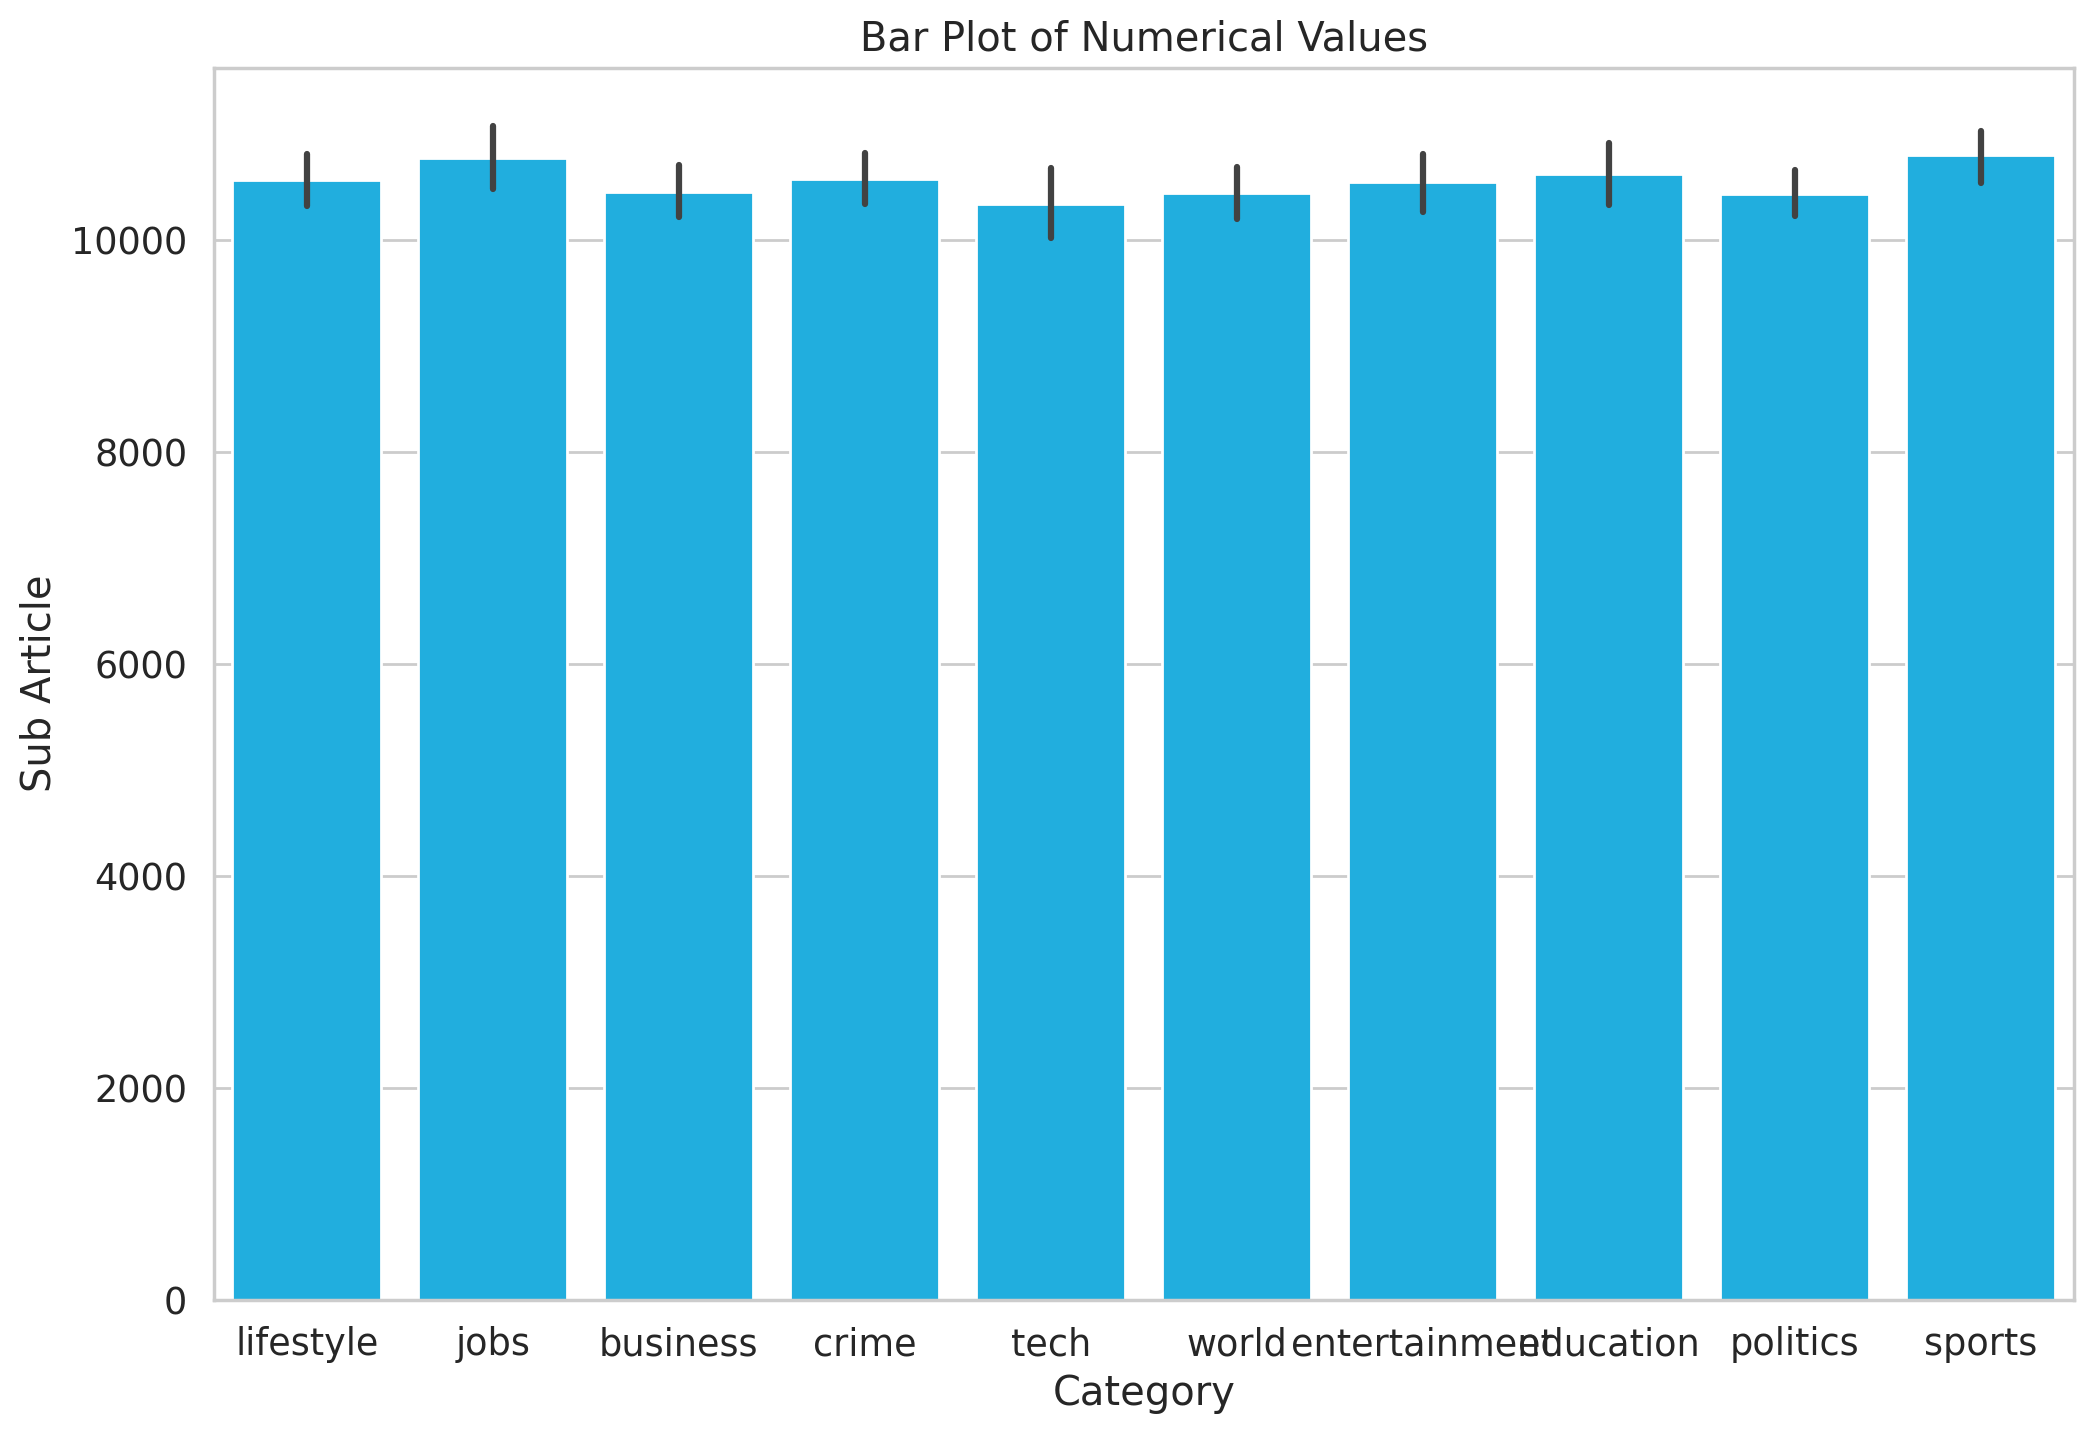

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'Text' is the column with text and 'Values' is the column with corresponding numerical values
# Adjust column names accordingly

# Plotting
sns.barplot(x='Category', y=df_train['Sub Article'].index, data=df_train)
plt.xlabel('Category')
plt.ylabel('Sub Article')
plt.title('Bar Plot of Numerical Values')
plt.show()


Text(0.5, 0, 'News\t')

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


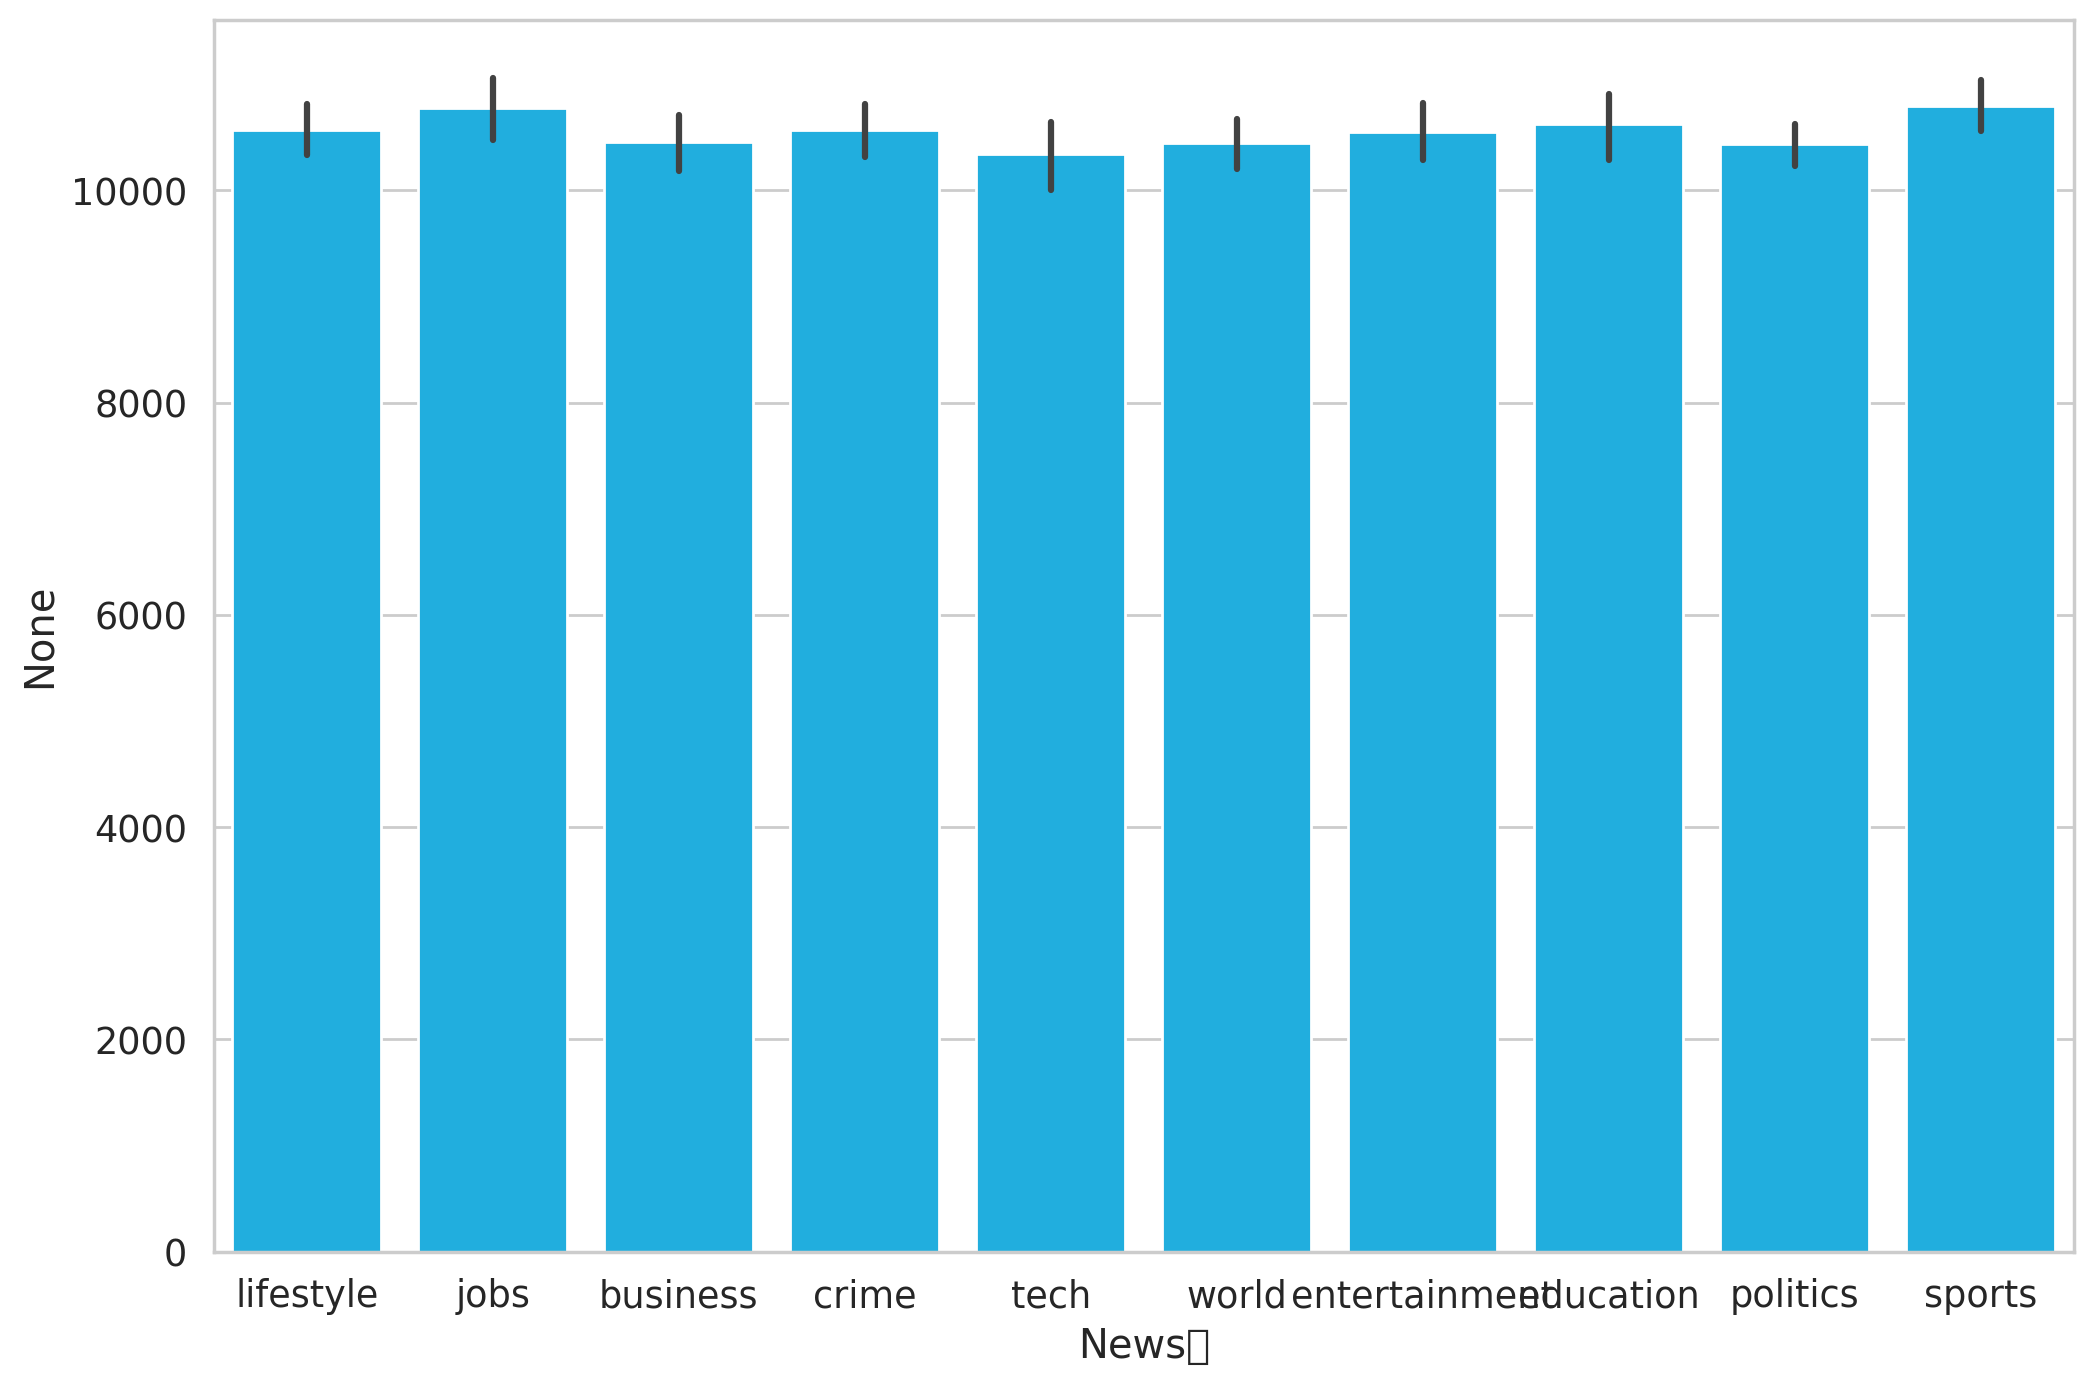

In [ ]:

sns.barplot(x='Category', y=df_train['Sub Article'].index, data=df_train)
plt.xlabel('News	')

Text(0.5, 0, 'News')

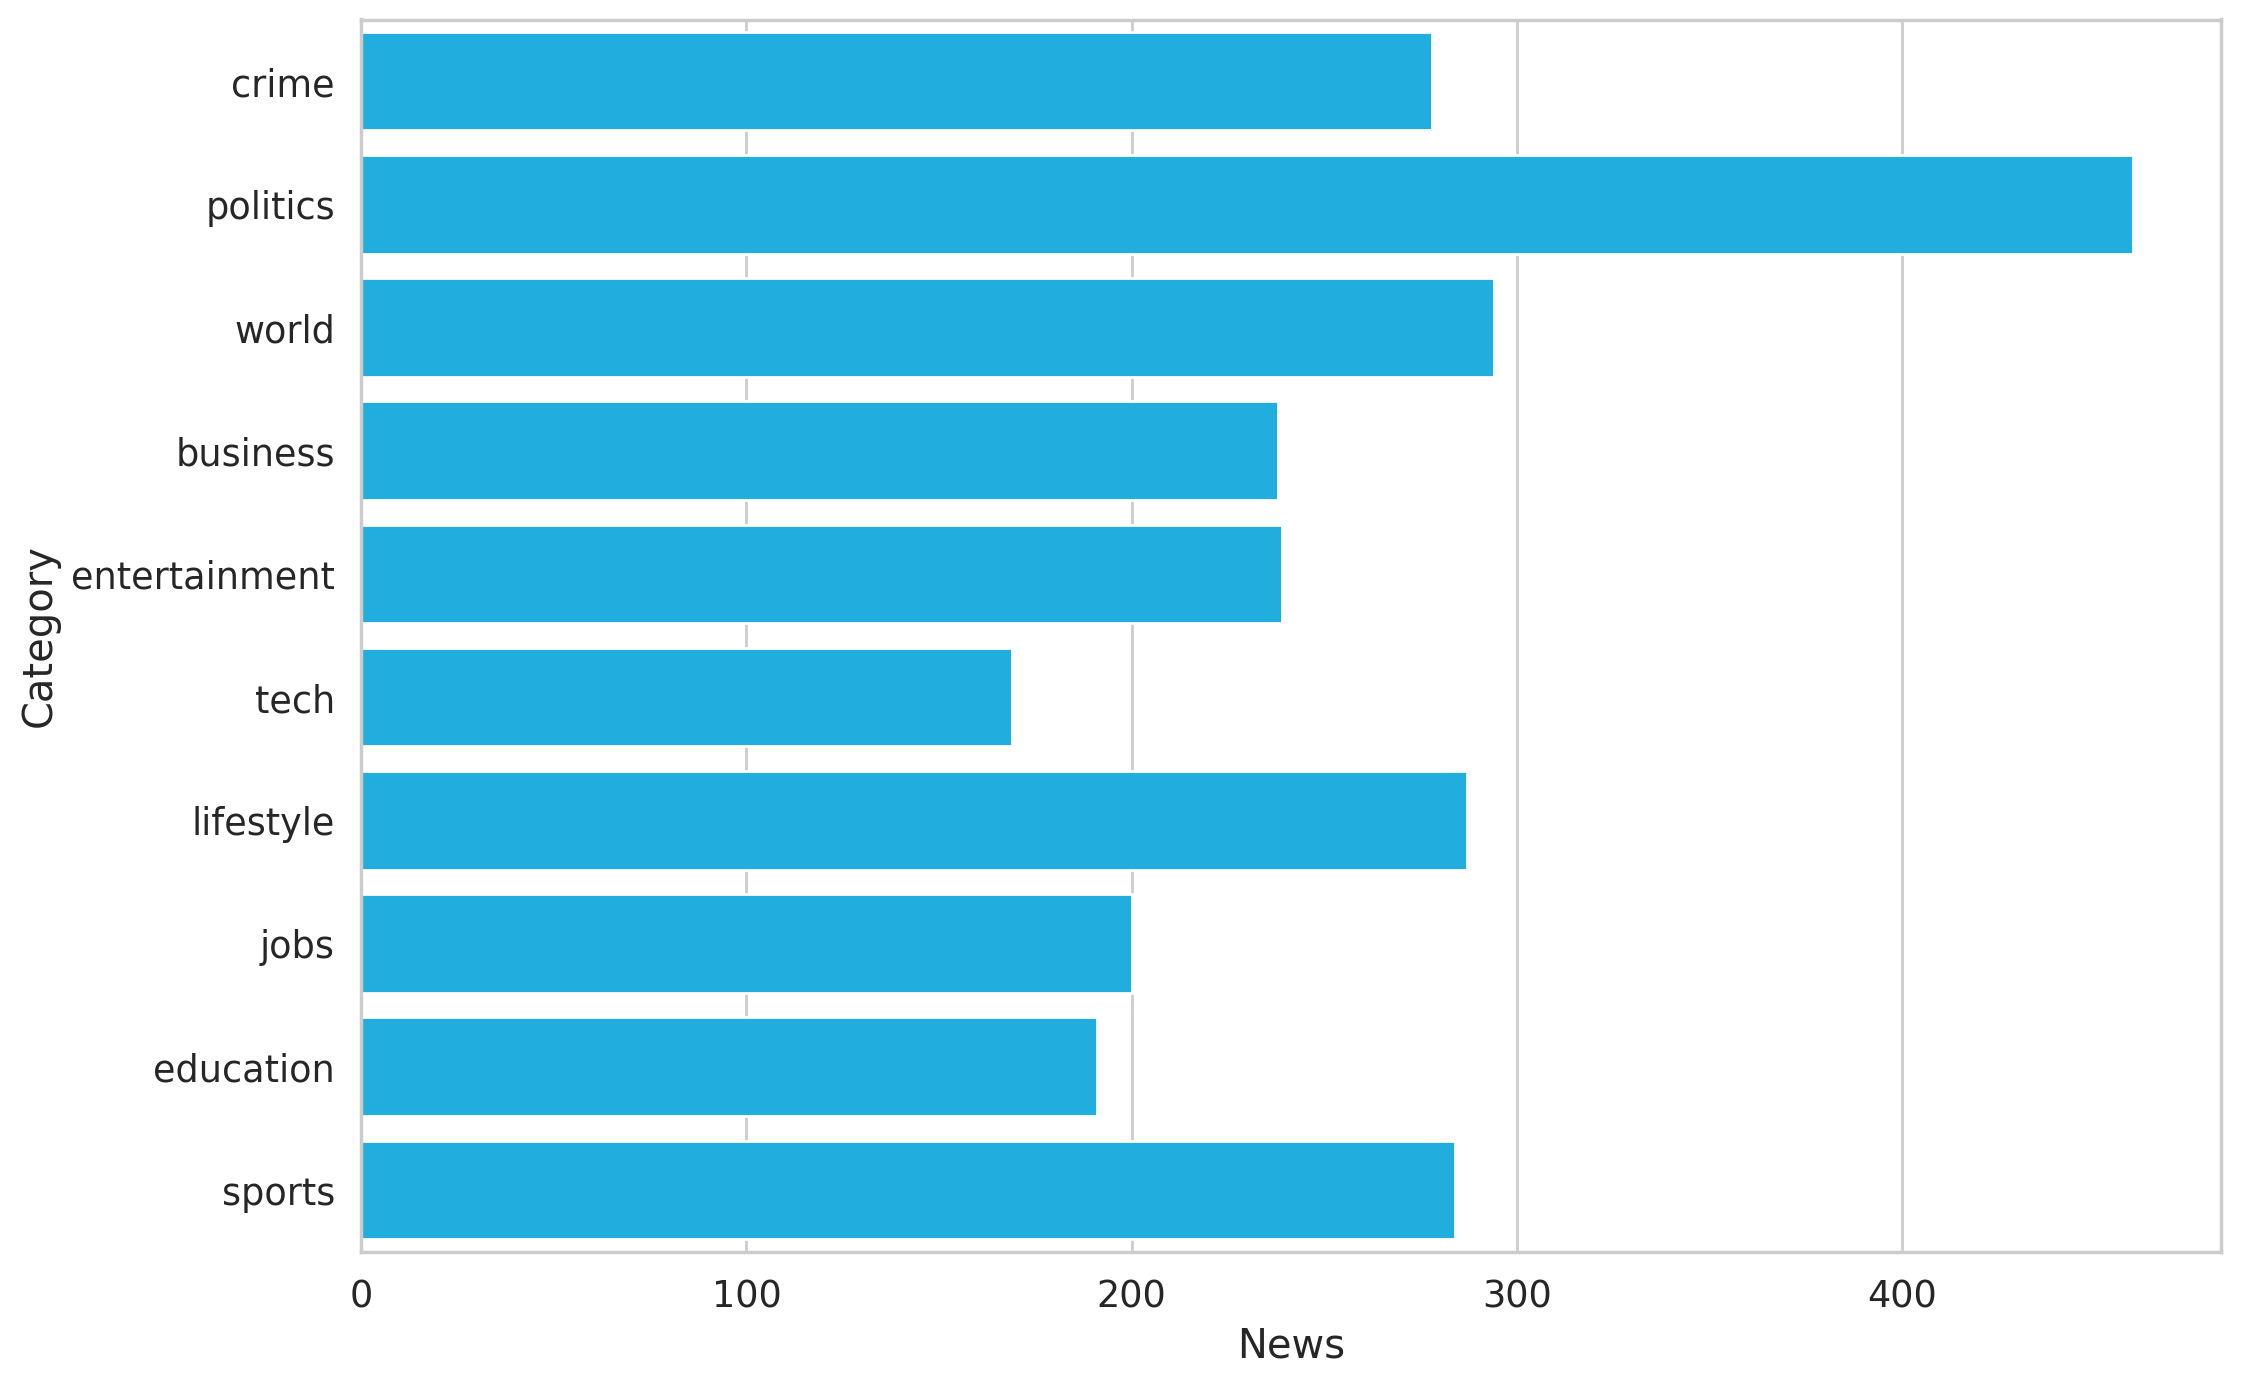

In [ ]:
sns.countplot(df_test.Category)
plt.xlabel('News')

Text(0.5, 0, 'News')

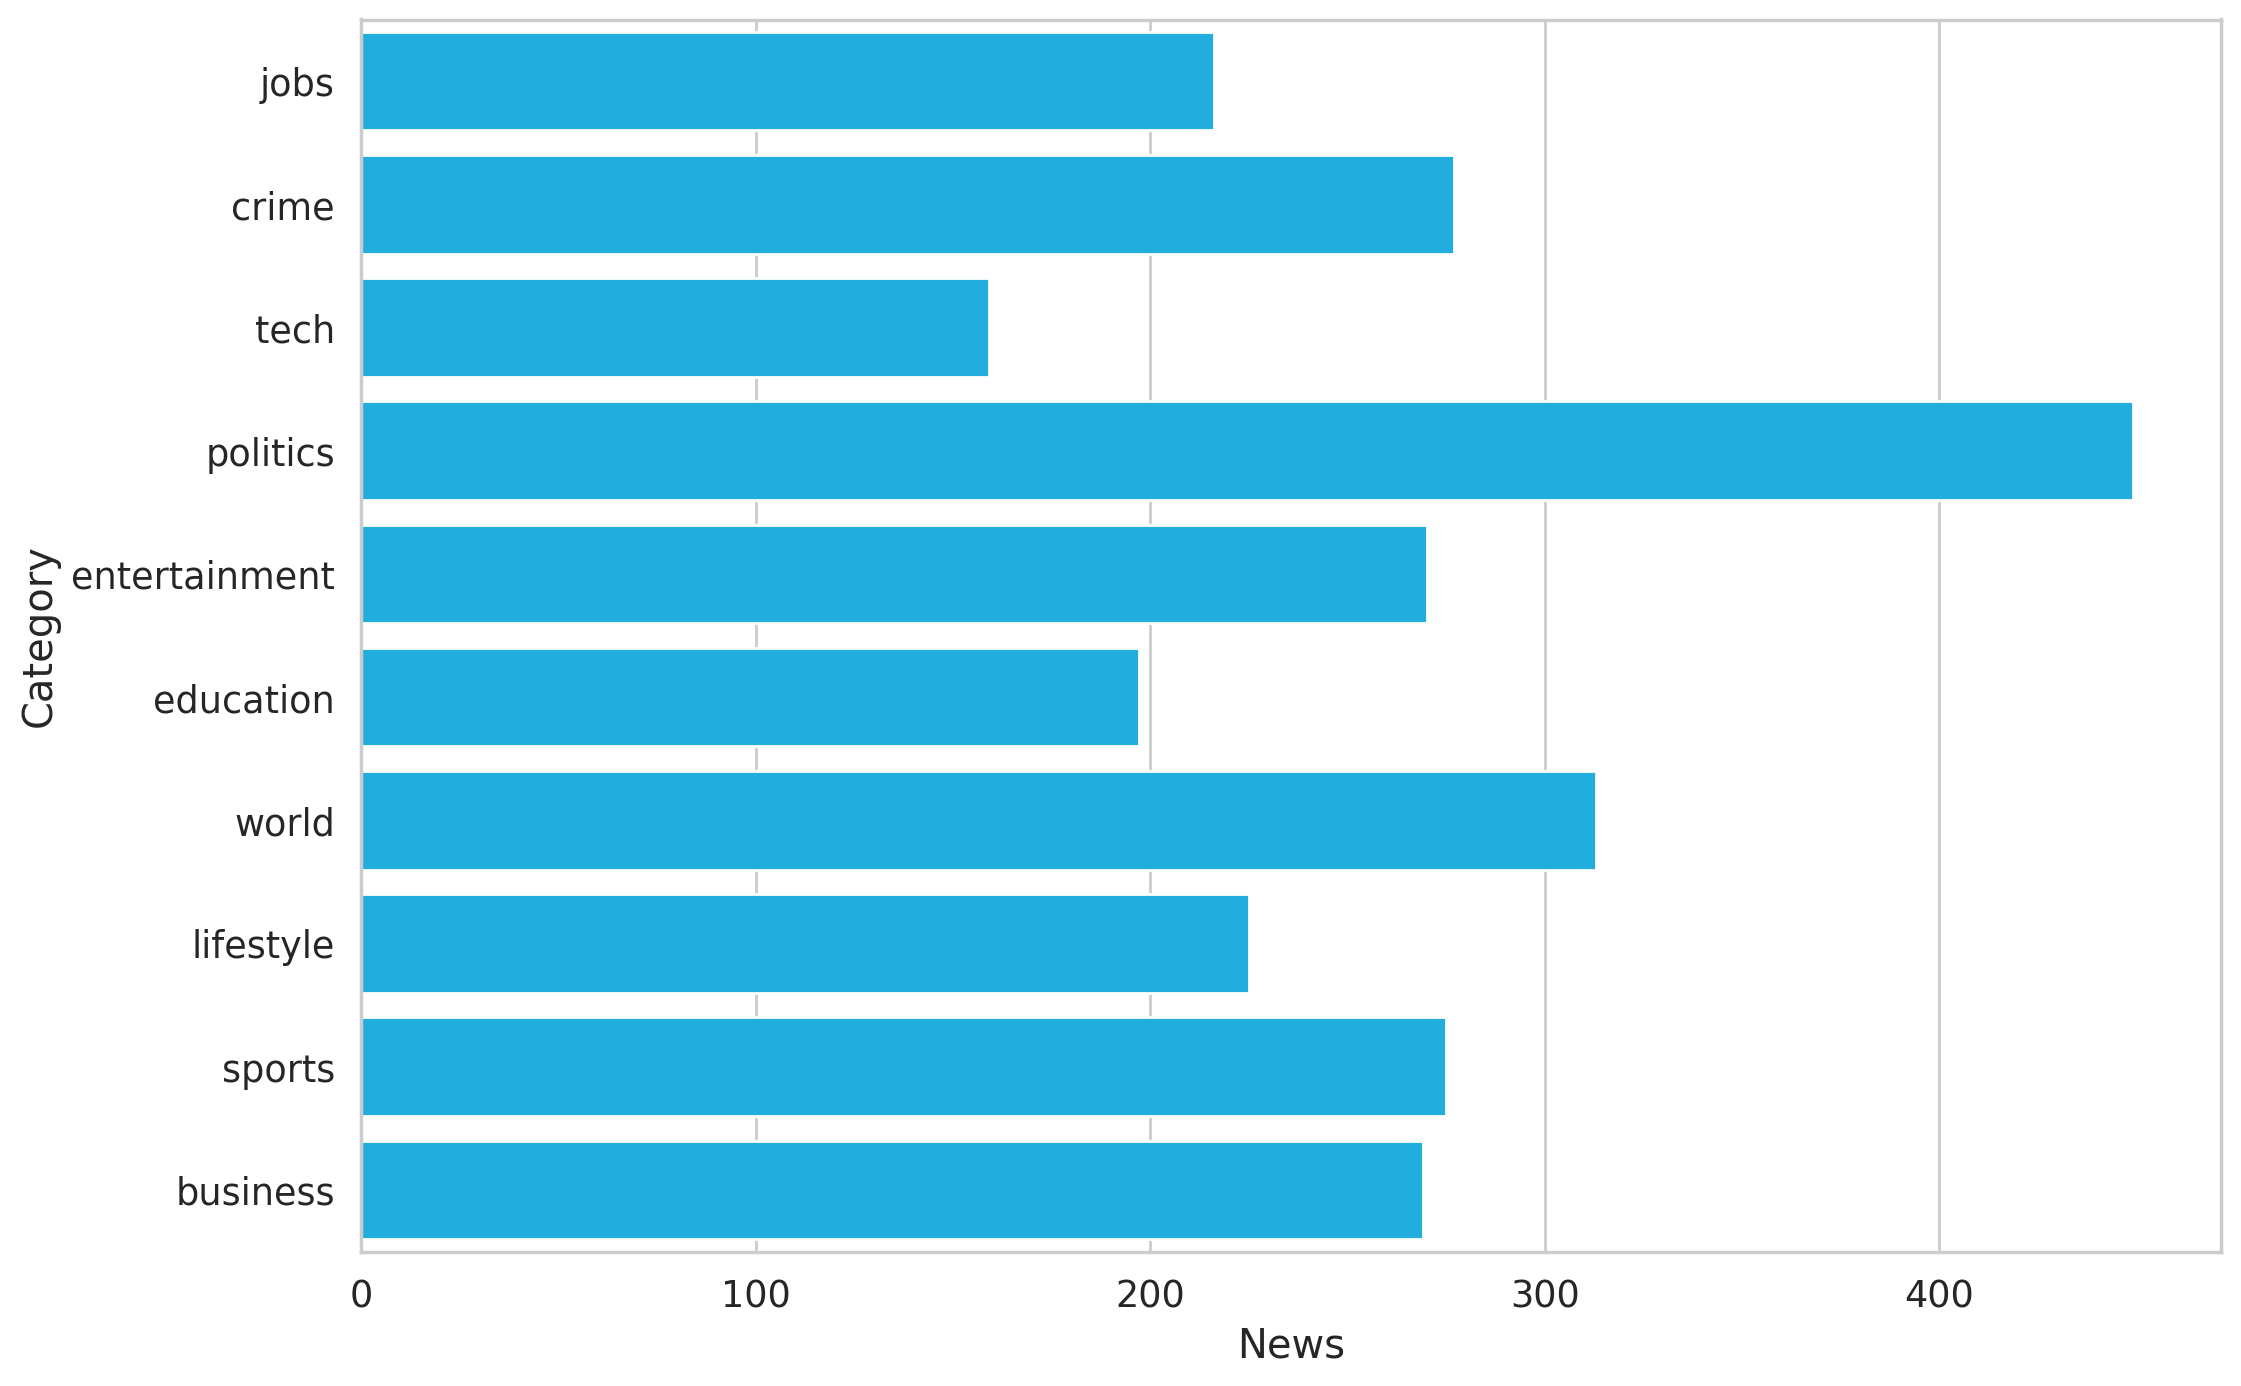

In [ ]:
sns.countplot(df_valid.Category)
plt.xlabel('News')

pd.set_option("display.max_colwidth", -1) is a Pandas function that sets the maximum width of columns when displayed. In this case, it's set to -1, which means that Pandas will display the full contents of each column without truncation. This is useful when you have long strings or texts in a DataFrame column, and you want to see the entire content without it being truncated in the output.







In [ ]:
pd.set_option("display.max_colwidth", None)  # Set to None for unlimited width, or use a positive integer
df_train.head(10)

,Title,Category,News,Sub Article
0,Digestive Biscuits: ఆ బిస్కెట్లు ఆరోగ్యానికి మంచిది కావా? ఏం జరుగుతుంది?,lifestyle,"టీ కప్పుతో పాటు చాలా మంది డైజెస్టివ్ బిస్కెట్స్ కూడా పెట్టుకుని తింటారు. తక్కువ కేలరీలు, అధిక ఫైబర్ ప్రత్యామ్నాయాలుగా ఉండే ఈ కుకీస్ ఆరోగ్యానికి మంచిదని భావిస్తారు. నోట్లో వేసుకుంటేనే కరిగిపోయే విధంగా తక్కువ తీపి రుచిని కలిగి ఉంటాయి. ముతక గోధుమ పిండి, కృత్రిమ రైజింగ్ ఏజెంట్లు, ఉప్పుతో తయారు చేస్తారు. రుచిని బట్టి బిస్కెట్లలో కొన్ని సార్లు ఓట్ మీల్, కల్చర్డ్ స్కిమ్డ్ మిల్క్, గింజల పొడి కూడా కలుపుతారు. ఆకలిని తగ్గించేందుకు, జీర్ణక్రియ మెరుగు పడేందుకు, బరువు తగ్గేందుకు సహాయపడే ఫైబర్ పుష్కలంగా ఉంటుంది. వీటిని తింటే ఆరోగ్యానికి మేలు చేస్తాయని అనుకుంటారు. కానీ ఈ డైజెస్టివ్ బిస్కెట్స్ క్రమం తప్పకుండా తీసుకోవడం వల్ల కొన్ని దుష్ప్రభావాలు ఉన్నాయి.ఆయిల్, మాల్ట్ ఎక్స్ ట్రాక్ట్, రైజింగ్ ఏజెంట్ వంటి పదార్థాలు డైజెస్టివ్ బిస్కెట్స్ లో ఉపయోగిస్తారు. ఆరోగ్య నిపుణుల అభిప్రాయం ప్రకారం ఈ బిస్కెట్లను అతిగా తినడం వల్ల ఎక్కువ హాని చేస్తుంది.డైజెస్టివ్ బిస్కెట్స్ ఎక్కువగా గోధుమలతో తయారవుతాయి. వీటిలో ఇనులిన్ అధికంగా ఉంటుంది. ఈ సమ్మేళనం సహజమైన అరటి పండ్లు, గోధుమలు, ఉల్లిపాయలు, వెల్లుల్లి వంటి అనేక ఇతర ఆహారాల్లో లభించే కార్బోహైడ్రేట్ ఫైబర్. ఇనులిన్ చిన్న పేగుల గుండా పెద్ద పేగుకు వెళుతుంది. అక్కడ అది మంచి బ్యాక్టీరియా పెరుగుదలను ప్రేరేపిస్తుంది.. చాలా మందిలో ఇది గ్యాస్, ఉబ్బరం, ఆపానవాయువు, విరోచనాలకు కారణమవుతుంది. అలాగే మాల్ట్ సారం అధికంగా తీసుకున్నప్పుడు ఆపానవాయువుకు కారణమవుతుంది.ఇందులో వాడే కూరగాయల నూనె ఉడికించినప్పుడు ట్రాన్స్ ఫ్యాట్లను ఉత్పత్తి చేస్తుంది. ఈ ట్రాన్స్ ఫ్యాట్ ఆరోగ్యానికి హానికరం. దగ్గుకు కారణమవుతుంది. జపనీస్ సొసైటీ ఆఫ్ ఇంటర్నల్ మెడిసిన్ నిర్వహించిన ఒక అధ్యయనం ప్రకారం కూరగాయల నూనె లైపోయిడ్ న్యుమోనియాకు కారణమవుతుంది. దీని వల్ల విపరీతమైన దగ్గు వస్తుంది.చాలా మందికి సోడియం బైకార్బొనేట్ వంటి ఏజెంట్లను పెంచడం వల్ల అలర్జీ ఉంటుంది. దీని ఎక్కువగా బిస్కెట్లు, బ్రెడ్లు,బేక్డ్ ఉత్పత్తులలో ఉపయోగిస్తారు. డైజెస్టివ్ బిస్కెట్లు సోడియం బైకార్బోనెట్ లు ఉపయోగిస్తాయి. దీన్ని అతిగా తీసుకుంటే దాహం వేస్తుంది. కడుపు తిమ్మిరి, గ్యాస్ వంటి సమస్యలు ఎదురవుతాయి.ఆరోగ్య నిపుణుల అభిప్రాయం ప్రకారం అధిక రక్తపోటు, గుండె వైఫల్యం లేదా మూత్రపిండాల వ్యాధి వంటి కొన్ని ఆరోగ్య పరిస్థితులు ఉన్న వాళ్ళు డైజెస్టివ్ బిస్కెట్స్ తింటే దుష్ప్రభావాలు ఎక్కువగా ఉంటాయి. సోడియం బైకార్బోనేట్ కడుపును గ్యాస్ ఏర్పరుస్తుంది. పేరుకే డైజెస్టివ్ బిస్కెట్స్ ఆరోగ్యమని అంటారు. కానీ ఇవి కూడా సాధారణ బిస్కెట్స్ మాదిరిగానే మారిపోయాయి. వీటిలో సంతృప్త కొవ్వులు ఉంటాయి. అందుకే వీటిని అతిగా తినడం మంచిది కాదు.గమనిక: పలు అధ్యయనాలు, పరిశోధనల నుంచి సేకరించిన సమాచారాన్ని ఇక్కడ యథావిధిగా అందించాం. ఇది వైద్య నిపుణుల సూచనలకు ప్రత్యామ్నాయం కాదు. తప్పకుండా వైద్యుడు లేదా ఆహార నిపుణుల సలహా తీసుకున్న తర్వాతే ఈ ఆహారాన్ని మీ డైట్‌లో చేర్చుకోవాలి. ఈ సమాచారం కేవలం మీ అవగాహన కోసమే.Also Read: లిప్ స్టిక్ వల్ల పెదాలు నల్లగా మారిపోతున్నాయా? ఇలా చేస్తే ఆ సమస్యే ఉండదు","ఆయిల్, మాల్ట్ ఎక్స్ ట్రాక్ట్, రైజింగ్ ఏజెంట్ వంటి పదార్థాలు డైజెస్టివ్ బిస్కెట్స్ లో ఉపయోగిస్తారు ఆరోగ్య నిపుణుల అభిప్రాయం ప్రకారం ఈ బిస్కెట్లను అతిగా తినడం వల్ల ఎక్కువ హాని చేస్తుందిడైజెస్టివ్ బిస్కెట్స్ ఎక్కువగా గోధుమలతో తయారవుతాయి వీటిలో ఇనులిన్ అధికంగా ఉంటుంది ఈ సమ్మేళనం సహజమైన అరటి పండ్లు, గోధుమలు, ఉల్లిపాయలు, వెల్లుల్లి వంటి అనేక ఇతర ఆహారాల్లో లభించే కార్బోహైడ్రేట్ ఫైబర్ ఇనులిన్ చిన్న పేగుల గుండా పెద్ద పేగుకు వెళుతుంది అక్కడ అది మంచి బ్యాక్టీరియా పెరుగుదలను ప్రేరేపిస్తుంది చాలా మందిలో ఇది గ్యాస్, ఉబ్బరం, ఆపానవాయువు, విరోచనాలకు కారణమవుతుంది అలాగే మాల్ట్ సారం అధికంగా తీసుకున్నప్పుడు ఆపానవాయువుకు కారణమవుతుందిఇందులో వాడే కూరగాయల నూనె ఉడికించినప్పుడు ట్రాన్స్ ఫ్యాట్లను ఉత్పత్తి చేస్తుంది ఈ ట్రాన్స్ ఫ్యాట్ ఆరోగ్యానికి హానికరం దగ్గుకు కారణమవుతుంది"
1,"AIIMS: నాగ్‌పూర్‌ ఎయిమ్స్‌లో 73 సీనియర్‌ రెసిడెంట్ పోస్టులు, అర్హతలివే!",jobs,"నాగ్‌పూర్‌లోని ఆల్ ఇండియా ఇన్‌స్టిట్యూట్ ఆఫ్ మెడికల్ సైన్సెస్(ఎయిమ్స్) వివిధ విభాగాలో ఖాళీగా ఉన్న సీనియర్‌ రెసిడెంట్ పోస్టుల భర్తీకి నోటిఫికేషన్ విడుదల చేసింది. దీనిద్వారా మొత్తం 73 పోస్టులను భర్తీ చేయనున్నారు. సంబంధిత స్పెషలైజేషన్‌లో పీజీ డిగ్రీ ఉత్తీర్ణత ఉన్నవారు దరఖాస్తు చేసుకోవడానికి అర్హులు. సరైన అర్హతలు గల అభ్యర్థులు ఆన్‌లైన్ ద్వారా దరఖాస్తులు సమర్పించాలి. ఈ పోస్టులకి దరఖాస్తు ప్రక్రియ జూన్ 9న ప్రారంభమైంది. జులై 8 వరకు దరఖ

# Preprocessing with transformers

In [ ]:
PRE_TRAINED_MODEL_NAME = 'google/muril-base-cased'

In [ ]:
  #Multilingual Representations for Indian Languages) model using the
  #AutoModel and AutoTokenizer classes from the transformers library.
muril_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/953M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/113 [00:00<?, ?B/s]

In [ ]:
sample_txt = 'టీ కప్పుతో పాటు చాలా మంది డైజెస్టివ్ బిస్కెట్స్ కూడా పెట్టుకుని తింటారు. తక్కువ కేలరీలు, అధిక ఫైబర్ ప్రత్యామ్నాయాలుగా ఉండే ఈ కుకీస్ ఆరోగ్యానికి మంచిదని భావిస్తారు.'

In [ ]:
len(sample_txt)

163

In [ ]:
from transformers import AutoTokenizer, AutoModel

model_name = 'google/muril-base-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

print("All Special Tokens:", tokenizer.all_special_tokens)
print("Special Tokens Map:", tokenizer.special_tokens_map)

# Example tokenization
text = "టీ కప్పుతో పాటు చాలా మంది డైజెస్టివ్ బిస్కెట్స్ కూడా పెట్టుకుని తింటారు. తక్కువ కేలరీలు, అధిక ఫైబర్ ప్రత్యామ్నాయాలుగా ఉండే ఈ కుకీస్ ఆరోగ్యానికి మంచిదని భావిస్తారు."
tokens = tokenizer.tokenize(text)
print("Tokens:", tokens)

All Special Tokens: ['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']
Special Tokens Map: {'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}
Tokens: ['టీ', 'కప్పు', '##తో', 'పాటు', 'చాలా', 'మంది', 'డై', '##జ', '##ెస్', '##టివ్', 'బి', '##స్', '##కెట్', '##స్', 'కూడా', 'పెట్టుకుని', 'తి', '##ంటారు', '.', 'తక్కువ', 'కే', '##లరీ', '##లు', ',', 'అధిక', 'ఫ', '##ైబర్', 'ప్రత్యామ్నాయ', '##ాలుగా', 'ఉండే', 'ఈ', 'కు', '##కీ', '##స్', 'ఆరోగ్యానికి', 'మంచి', '##దని', 'భావిస్తారు', '.']


In [ ]:

# Tokenize the text
tokens = tokenizer.tokenize(sample_txt)
# converts the list of tokens into their corresponding token IDs
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')



 Sentence: టీ కప్పుతో పాటు చాలా మంది డైజెస్టివ్ బిస్కెట్స్ కూడా పెట్టుకుని తింటారు. తక్కువ కేలరీలు, అధిక ఫైబర్ ప్రత్యామ్నాయాలుగా ఉండే ఈ కుకీస్ ఆరోగ్యానికి మంచిదని భావిస్తారు.
   Tokens: ['టీ', 'కప్పు', '##తో', 'పాటు', 'చాలా', 'మంది', 'డై', '##జ', '##ెస్', '##టివ్', 'బి', '##స్', '##కెట్', '##స్', 'కూడా', 'పెట్టుకుని', 'తి', '##ంటారు', '.', 'తక్కువ', 'కే', '##లరీ', '##లు', ',', 'అధిక', 'ఫ', '##ైబర్', 'ప్రత్యామ్నాయ', '##ాలుగా', 'ఉండే', 'ఈ', 'కు', '##కీ', '##స్', 'ఆరోగ్యానికి', 'మంచి', '##దని', 'భావిస్తారు', '.']
Token IDs: [32566, 136331, 1873, 2024, 4328, 5854, 182027, 16967, 44254, 52442, 2889, 2417, 84977, 2417, 1417, 110319, 106557, 31677, 121, 15095, 62058, 161649, 1564, 119, 21028, 875, 145044, 3697, 120555, 14598, 845, 4282, 17101, 2417, 186114, 9141, 21573, 58380, 121]


You can still use GPT-2 for various NLP tasks, but the tokenization and input format might differ from models like BERT that use [SEP] tokens for specific purposes like sentence separation

In [ ]:
# from transformers import GPT2Tokenizer

# # Replace 'your_model_name' with the actual model name or path
# model_name = 'google/muril-base-cased'
# tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
# print(tokenizer.sep_token, tokenizer.sep_token_id)
# print(tokenizer.cls_token, tokenizer.cls_token_id)

None None
None None


In [ ]:
from transformers import AutoTokenizer

model_name = 'google/muril-base-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)

[SEP] 105
[CLS] 104


In [ ]:
 #Print Separation Token and ID  eparation token (often used to indicate the end of a sequence) and its corresponding token ID.
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)    #Print Classification Token and ID
print(tokenizer.pad_token, tokenizer.pad_token_id)  #padding token and Id
print(tokenizer.unk_token, tokenizer.unk_token_id)   # Unknown token and Id

[SEP] 105
[CLS] 104
[PAD] 0
[UNK] 100


In [ ]:
 tokenizer.sep_token_id

105

In [ ]:
tokenizer.sep_token

'[SEP]'

In [ ]:


encoding = tokenizer.encode_plus(
  sample_txt,                                                                          # This is the input text that you want to encode
  max_length=32,     # Max no. of tokens   #It specifies the maximum length of the output sequence. If the tokenized sequence is longer than max_length, it will be truncated. If it is shorter, it will be padded.
   truncation=True,
  add_special_tokens=True,                                                # Add special tokens like  '[CLS]'(classification) and '[SEP]'(separator)
  return_token_type_ids=True,                                          # When set to True, it returns token type IDs, which are used in models that accept pairs of sequences (e.g., question-answering)
  padding='max_length',
  pad_to_max_length=True,                                               # When set to True, it pads the sequence to the specified max_length if it is shorter. Padding is done with the [PAD] token.
  return_attention_mask=True,                                          # When set to True, it returns an attention mask indicating which tokens should be attended to and which ones should be ignored (typically 1 for tokens and 0 for padding).
  return_tensors='pt',                                                            # Return PyTorch tensors  # It specifies that the output should be in PyTorch tensors.
)

encoding.keys()                                                # This returns the keys of the dictionary containing the encoded information. The typical keys include 'input_ids', 'token_type_ids', and 'attention_mask'.



dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
# input_ids = encoding['input_ids']
#token_type_ids = encoding['token_type_ids']
#attention_mask = encoding['attention_mask']

# Now you can use input_ids, token_type_ids, and attention_mask as PyTorch tensors in your model

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids']

32


tensor([[   104,  32566, 136331,   1873,   2024,   4328,   5854, 182027,  16967,
          44254,  52442,   2889,   2417,  84977,   2417,   1417, 110319, 106557,
          31677,    121,  15095,  62058, 161649,   1564,    119,  21028,    875,
         145044,   3697, 120555,  14598,    105]])

In [ ]:
print(len(encoding['token_type_ids'][0]))
encoding['token_type_ids']

32


tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]])

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0].tolist())         #input token IDs back to their corresponding tokens (words or subwords) in the vocabulary

['[CLS]',
 'టీ',
 'కప్పు',
 '##తో',
 'పాటు',
 'చాలా',
 'మంది',
 'డై',
 '##జ',
 '##ెస్',
 '##టివ్',
 'బి',
 '##స్',
 '##కెట్',
 '##స్',
 'కూడా',
 'పెట్టుకుని',
 'తి',
 '##ంటారు',
 '.',
 'తక్కువ',
 'కే',
 '##లరీ',
 '##లు',
 ',',
 'అధిక',
 'ఫ',
 '##ైబర్',
 'ప్రత్యామ్నాయ',
 '##ాలుగా',
 'ఉండే',
 '[SEP]']

In [ ]:
token_lens = []
for txt in tqdm(df_train['Category']): # Replace '<actual_column_name>' with the correct name of the column containing the tweets
  tokens = tokenizer.encode(txt, max_length=512, truncation=True, padding='max_length')
  token_lens.append(len(tokens))

100%|██████████| 21103/21103 [00:03<00:00, 5413.15it/s]


trail above category

In [ ]:
token_lens = []
for txt in tqdm(df_train.News	):                     #tqdm provides a flexible and customizable way to visualize the progress of loops, file downloads, data processing, or any other iterable process
  tokens = tokenizer.encode(txt, max_length=512)   #his line tokenizes the text using the specified tokenizer and enforces a maximum length of 512 tokens. The tokenizer.encode method typically performs tokenization and includes special tokens (e.g., [CLS] and [SEP]).
  token_lens.append(len(tokens))                                  # The length of each tokenized sequence is appended to the token_lens list.   This list will store the lengths of tokenized sequences for each text in the DataFrame.

100%|██████████| 21103/21103 [00:53<00:00, 394.20it/s]


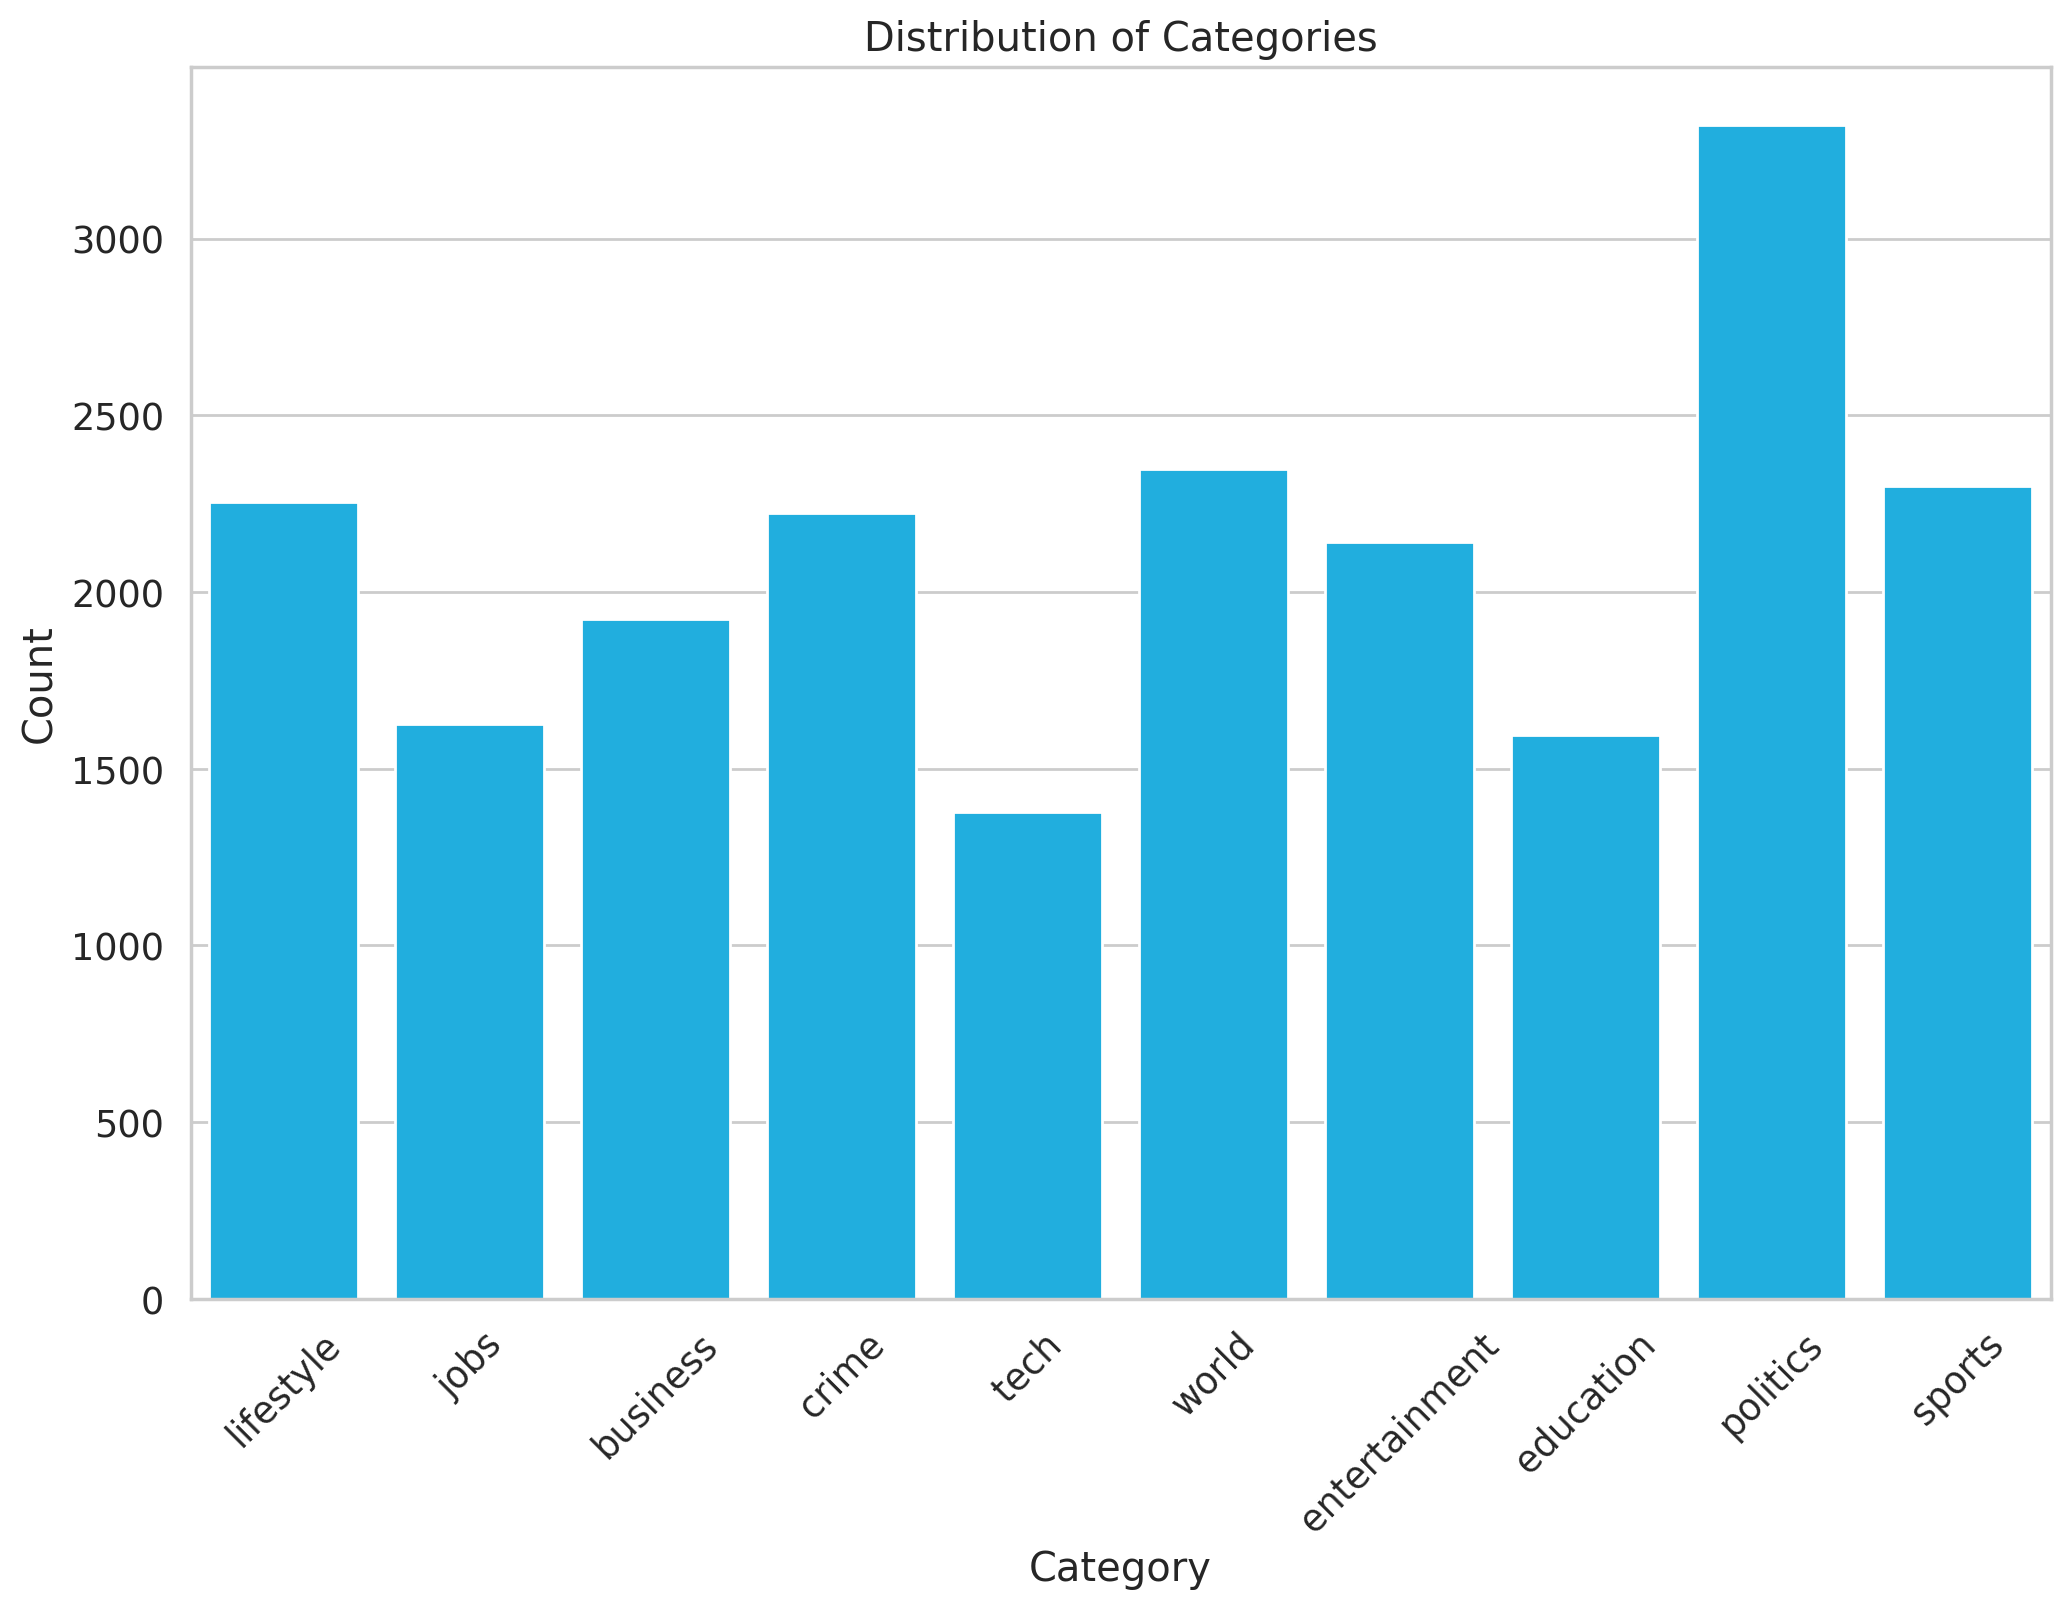

In [ ]:
# Plotting the distribution of categories
sns.countplot(x='Category', data=df_train)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Distribution of Categories')
plt.xticks(rotation=45)  # Rotate x labels if needed
plt.show()

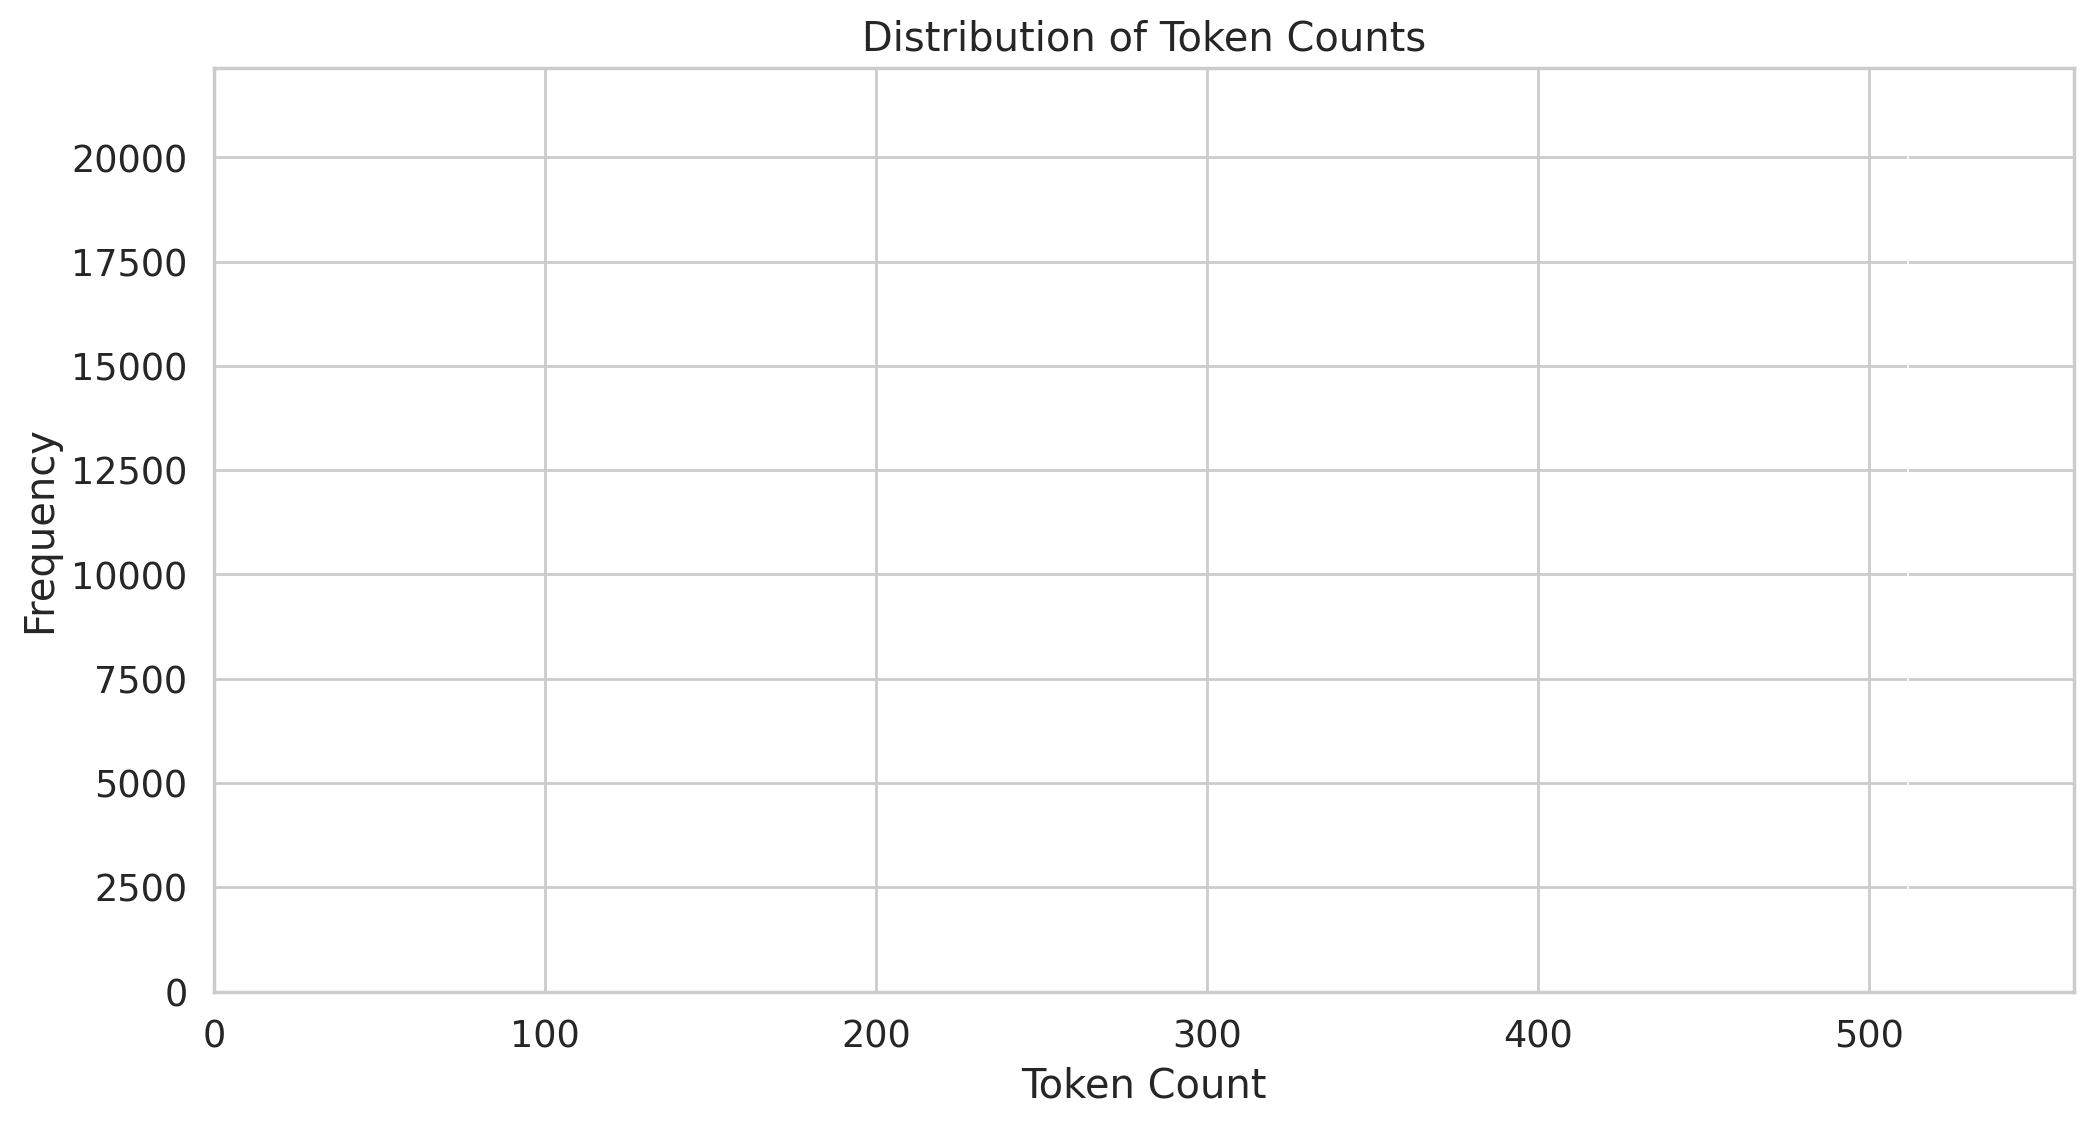

In [ ]:
plt.figure(figsize=(12, 6))  # Increase plot size for better visibility
sns.histplot(token_lens, bins=100, kde=True)  # Adjust number of bins if needed
plt.xlim([0, max(token_lens) + 50])  # Extend x-axis limit based on the max token length
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.title('Distribution of Token Counts')
plt.show()

<ipython-input-31-7abff62f5f77>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)            # sns seaborn ,token_lens is the list containing the lengths of tokenized sequences for each text in the dataset. This line creates a distribution plot using the seaborn library. The distplot function is used to visualize the distribution of a dataset.


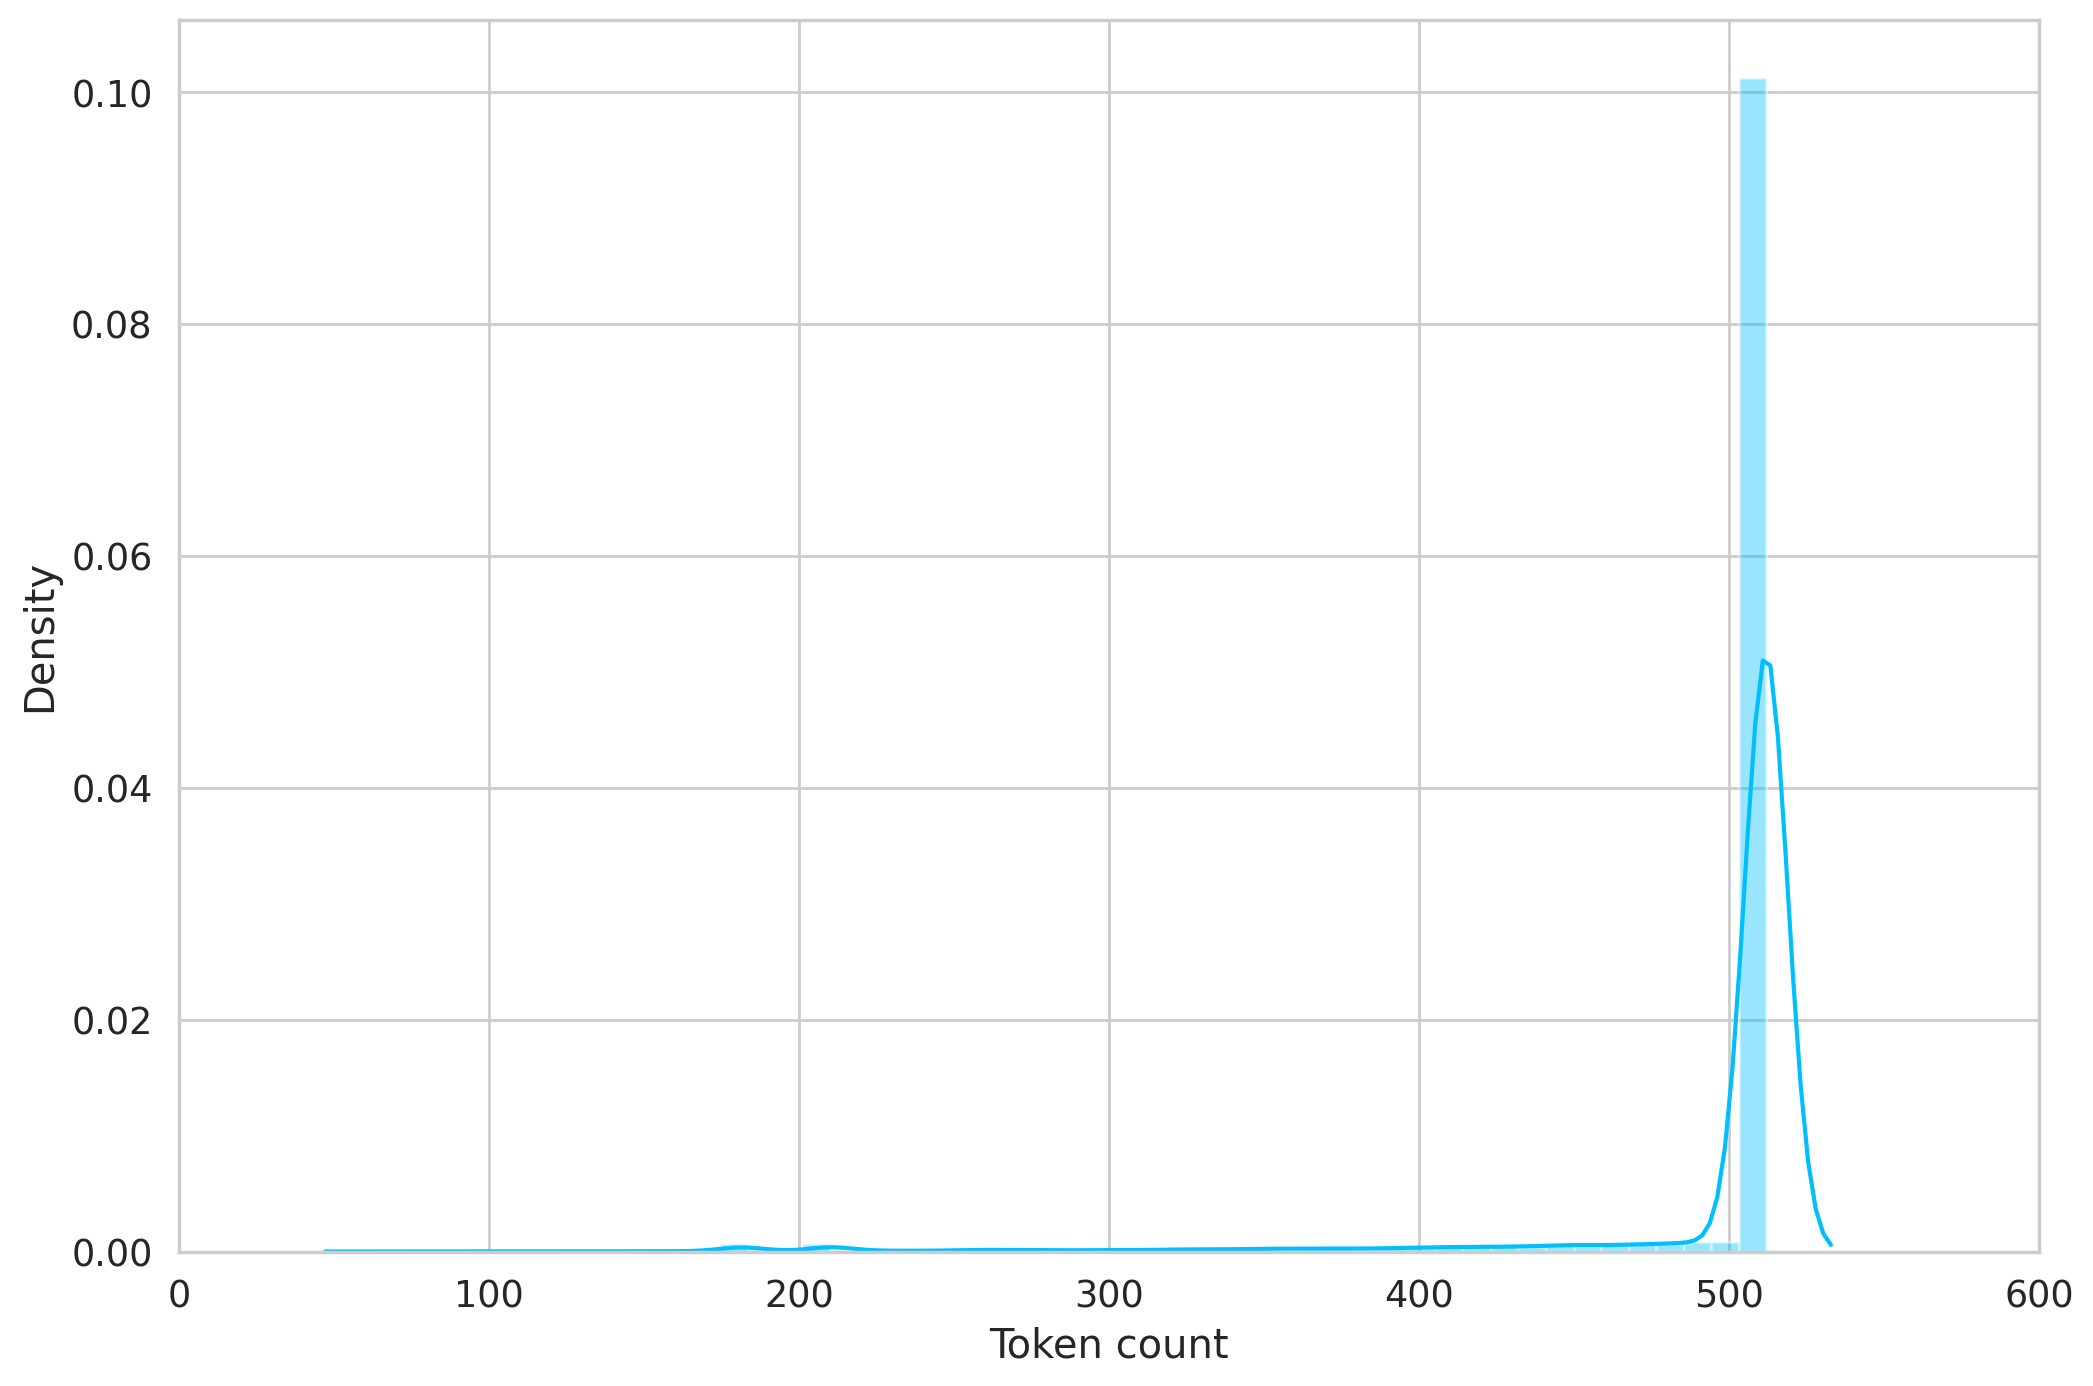

In [ ]:
sns.distplot(token_lens)            # sns seaborn ,token_lens is the list containing the lengths of tokenized sequences for each text in the dataset. This line creates a distribution plot using the seaborn library. The distplot function is used to visualize the distribution of a dataset.
plt.xlim([0, 600]);
plt.xlabel('Token count');
plt.show()

In [ ]:
MAX_LEN = 160  #This ensures that the resulting tokenized sequences will be truncated or padded to a maximum length of 160 tokens.

In [ ]:
class GPReviewDataset(Dataset):                                          #  his code defines a PyTorch dataset class named GPReviewDataset for handling text data with associated targets (labels).

  def __init__(self, text, targets, tokenizer, max_len):         #Constructor (__init__):
    self.text = text
    self.targets = targets
    self.tokenizer = tokenizer                                                         #A tokenizer (presumably from the Transformers library) for encoding the text.
    self.max_len = max_len                                                          #The maximum length to truncate or pad the tokenized sequences.

  def __len__(self):                                                                   #__len__ Method:     Returns the total number of samples in the dataset (the length of the text).
    return len(self.text)

  def __getitem__(self, item):                                        #__getitem__ Method:     Takes an index item and returns a dictionary containing the following  tweet_text input_ids,attention_mask,type_ids,targets
    text = str(self.text[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(                    #Uses the provided tokenizer (self.tokenizer) to tokenize and encode the input text.
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      truncation=True,
      return_token_type_ids=True,
      return_attention_mask=True,
      padding= 'max_length',
      # pad_to_max_length = True,
      return_tensors='pt',
    )

    return {                                                        #he dictionary returned by __getitem__ contains various elements necessary for training or inference with a transformer-based model.
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'type_ids': encoding['token_type_ids'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train.shape, df_valid.shape, df_test.shape              #df_train.shape returns a tuple representing the dimensions of the DataFrame ,,,  first element of the tuple is the number of rows , ,,The second element of the tuple is the number of columns

((21103, 4), (2650, 4), (2640, 4))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):                  #takes a DataFrame (df a tokenizer, a maximum sequence length (max_len), and a batch size (batch_size) as inputs.                             # purpose of this function is to create a PyTorch DataLoader for efficiently loading and batching the data during training or evaluation.
  ds = GPReviewDataset(                                   #A PyTorch DataLoader is initialized with the created dataset (ds).
    text=df.News.to_numpy(),
    targets=df.Category.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2,             #num_workers enables parallel data loading, speeding up the process, especially when dealing with large datasets.
    shuffle=True
  )

trail below

In [ ]:
import torch
from torch.utils.data import DataLoader

def create_data_loader(df, tokenizer, max_len, batch_size):
    """
    Creates a DataLoader for the given DataFrame.

    Args:
        df (pandas.DataFrame): DataFrame containing 'News' and 'Category' columns.
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer to use for encoding text.
        max_len (int): Maximum length of the tokenized sequences.
        batch_size (int): Batch size for the DataLoader.

    Returns:
        DataLoader: A DataLoader for the dataset.
    """
    # Ensure 'Category' is encoded as integer labels
    if df['Category'].dtype == 'object':
        df['Category'] = df['Category'].astype('category').cat.codes

    ds = GPReviewDataset(
        text=df['News'].to_numpy(),
        targets=df['Category'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=2,  # Adjust based on your system's capabilities
        shuffle=True
    )


In [ ]:
BATCH_SIZE = 16
                         #create_data_loader function to create PyTorch DataLoaders for your training (df_train), validation (df_valid), and test (df_test)
max_len = MAX_LEN
train_data_loader = create_data_loader(df_train, tokenizer, max_len, BATCH_SIZE)
val_data_loader = create_data_loader(df_valid, tokenizer, max_len, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, max_len, BATCH_SIZE)


In [ ]:
data = next(iter(train_data_loader))
print("Target values from DataLoader:", data["targets"])


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79a8f0fe2320><function _MultiProcessingDataLoaderIter.__del__ at 0x79a8f0fe2320>

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():Traceback (most recent call last):

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Target values from DataLoader: tensor([1, 6, 2, 5, 7, 8, 3, 8, 6, 3, 0, 5, 2, 5, 5, 8])


trail above

In [ ]:
data = next(iter(train_data_loader))         #The iter function is used to create an iterator from the train_data_loader. An iterator allows you to iterate over the batches of data.
data.keys()                                     #checking the keys (or field names) present in this dictionary

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-34-562acfeae092>", line 33, in __getitem__
    'targets': torch.tensor(target, dtype=torch.long)
TypeError: new(): invalid data type 'str'


print(data['input_ids'].shape):

This line prints the shape of the tensor representing the input IDs of the tokenized sequences in the batch.
Why: Understanding the shape of the input IDs tensor is crucial for knowing the dimensionality of the input data that will be fed into your neural network model. It helps ensure that the input data has the expected structure.

In [ ]:
print(data['input_ids'].shape)            # prints the shape of the tensor representing the input IDs of the tokenized sequences in the batch.
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


# Classification

The 'attention_mask' is a binary mask indicating which positions in the input sequence are valid and which are padded. It has a value of 1 for valid positions and 0 for padded positions.

Printing 'attention_mask' helps you visually inspect how the tokenization process handles padding. It's useful for confirming that the attention mask is correctly set to 1 for actual tokens and 0 for padded tokens.

token_type_ids' typically represents the segment or type of each token in the input sequence. In models like BERT, which accept two segments (e.g., sentence A and sentence B), this tensor helps differentiate between the tokens from different segments.

Printing 'token_type_ids' is useful when working with models that use token types as input, as it allows you to verify that the tokens are assigned the correct types. It helps ensure that the model can distinguish between different parts of the input sequence.

In [ ]:
print(encoding['attention_mask'] , encoding['token_type_ids'])

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]]) tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])


muril_model is a pre-trained model, possibly MURIL (Multilingual Representations for Indian Languages). It's being used to process a batch of input sequences represented by encoding.

encoding['input_ids'] contains the tokenized input sequences converted to numerical IDs.

encoding['attention_mask'] is a binary mask indicating which positions in the input sequence are valid (1) and which are padded (0).

encoding['token_type_ids'] represents the segment or type of each token, distinguishing different segments if applicable.

The model is invoked with these inputs to obtain the output tensor x\

Model Inference: This code performs inference using the pre-trained MURIL model on a specific batch of input sequences.

Tokenization and Encoding: The input sequences are tokenized and encoded using the provided 'input_ids', 'attention_mask', and 'token_type_ids'. These representations are then passed to the model.

In [ ]:
x = muril_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask'],
  token_type_ids=encoding['token_type_ids']
)

x['last_hidden_state'] represents the last layer's hidden states of the MURIL model for each token in the input sequence. It is a 3D tensor with dimensions (batch_size, sequence_length, hidden_size).

x['pooler_output'] represents the aggregated representation of the entire input sequence. It is a 2D tensor with dimensions (batch_size, hidden_size).

Hidden States: The last_hidden_state contains the contextualized embeddings for each token in the input sequence. It retains information about how each token is influenced by the context of the entire sequence.

Pooling: The pooler_output is a summary or aggregation of the entire sequence. It is often used as a representation of the entire input sequence, condensing the information from all tokens into a single vector.

Downstream Tasks: Both last_hidden_state and pooler_output can be used for various downstream tasks in natural language processing (NLP), such as text classification, named entity recognition, or sentiment analysis.

Choosing Representation: Depending on the task, you might choose to use the last_hidden_state for token-level information or the pooler_output for a sequence-level representation.


In [ ]:
print(x['last_hidden_state'].shape, x['pooler_output'].shape)

torch.Size([1, 32, 768]) torch.Size([1, 768])


muril_model.config.hidden_size represents the number of dimensions in the hidden states of the model.

Model Capacity: The hidden_size is a crucial hyperparameter that determines the model's capacity to capture and represent information. A higher hidden size allows the model to learn more complex patterns and relationships in the data but comes at the cost of increased computational requirements.

Representation Dimensionality: Each token in the input sequence is associated with a hidden state vector of size hidden_size. This vector captures the learned features and contextual information for that token.

Embedding Dimensionality: The embedding layers (input embeddings and positional embeddings) transform input tokens into vectors of dimension hidden_size.

Model Flexibility: The choice of hidden_size is often influenced by the specific task and the available computational resources. Larger hidden_size values may be beneficial for more complex tasks or larger datasets.

In [ ]:
muril_model.config.hidden_size

768

what __init__ Method:

n_classes: Number of classes in the sentiment classification task.
base: Pre-trained MURIL model used as the base for feature extraction.
Components:

muril: Pre-trained MURIL model.
drop1: Dropout layer to prevent overfitting after the MURIL model's pooler output.
lstm: Bidirectional LSTM layer to capture sequential information.
out1: Linear layer to transform LSTM output to a smaller dimension.
relu: Rectified Linear Unit (ReLU) activation function.
drop2: Dropout layer after the ReLU activation.
out: Final linear layer for classification.
forward Method:

Takes input IDs, attention mask, and token type IDs as input.
Passes the inputs through the pre-trained MURIL model (muril) to get the pooler output.
Applies dropout (drop1) after the pooler output.
Adjusts the dimensions and passes the output through a bidirectional LSTM layer (lstm) to capture sequential information.
Reshapes the LSTM output and passes it through a linear layer (out1) with ReLU activation.
Applies dropout (drop2) after the ReLU activation.
Passes the final output through the linear layer (out) for sentiment classification.


why Transfer Learning: Leverages pre-trained MURIL weights for contextualized token representations.
Sequential Information: Introduces an LSTM layer to capture sequential dependencies in the token representations.
Non-Linearity: Applies ReLU activation to introduce non-linearity to the model.
Dropout: Helps prevent overfitting by randomly dropping units during training.
Classification Layer: Produces the final output logits for sentiment classification.

In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes, base):
        super(SentimentClassifier, self).__init__()
        self.muril = base
        self.drop1 = nn.Dropout(p=0.3)
        self.lstm = nn.LSTM(base.config.hidden_size, 150, num_layers=2, bidirectional=True, dropout=0.2)  # Increased num_layers
        self.out1 = nn.Linear(300, 64)
        self.relu = nn.ReLU()
        self.drop2 = nn.Dropout(p=0.1)
        self.out = nn.Linear(64, n_classes)

    def forward(self, input_ids, attention_mask, token_type_ids):
        x = self.muril(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        pooled_output = x['pooler_output']
        output = self.drop1(pooled_output)
        output = output.view(len(output), 1, -1)
        output, _ = self.lstm(output)
        output = output.view(len(output), output.shape[-1])
        output = self.relu(self.out1(output))
        output = self.drop2(output)
        return self.out(output)


trail above

In [ ]:

class SentimentClassifier(nn.Module):

  def __init__(self, n_classes, base):
    super(SentimentClassifier, self).__init__()
    self.muril = base
    self.drop1 = nn.Dropout(p=0.3)
    self.lstm = nn.LSTM(base.config.hidden_size, 150,bidirectional=True,dropout=0)
    self.out1 = nn.Linear(300,64)
    self.relu = nn.ReLU()
    self.drop2 = nn.Dropout(p=0.1)
    self.out = nn.Linear(64, n_classes)

  def forward(self, input_ids, attention_mask, token_type_ids):
    x = self.muril(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )
    pooled_output = x['pooler_output']
    output = self.drop1(pooled_output)
    output = output.view(len(output), 1, -1)
    output, _ = self.lstm(output)
    output = output.view(len(output), output.shape[-1])
    output =self.relu(self.out1(output))
    output = self.drop2(output)
    return self.out(output)

Class Names:

The class_names list is used to interpret the model's output logits. Each index of the output corresponds to a sentiment class, and the class with the highest probability is considered the predicted sentiment.
Model Initialization:

Initializes an instance of the SentimentClassifier model. The length of class_names is passed as the number of classes for sentiment classification.
The pre-trained MURIL model is used as the base for feature extraction, combining contextualized embeddings with sequential information.
Move Model to Device:

If GPU acceleration is available (device is set to a GPU), this line of code moves the entire model (including its parameters) to the specified device.

In [ ]:
import os
import torch
import torch.nn as nn
from transformers import AutoModel

# Set CUDA_LAUNCH_BLOCKING for debugging
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model class
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes, base):
        super(SentimentClassifier, self).__init__()
        self.muril = base
        self.drop1 = nn.Dropout(p=0.3)
        self.lstm = nn.LSTM(base.config.hidden_size, 150, num_layers=2, bidirectional=True, dropout=0.2)
        self.out1 = nn.Linear(300, 64)
        self.relu = nn.ReLU()
        self.drop2 = nn.Dropout(p=0.1)
        self.out = nn.Linear(64, n_classes)

    def forward(self, input_ids, attention_mask, token_type_ids):
        x = self.muril(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        pooled_output = x['pooler_output']
        output = self.drop1(pooled_output)
        output = output.view(len(output), 1, -1)
        output, _ = self.lstm(output)
        output = output.view(len(output), output.shape[-1])
        output = self.relu(self.out1(output))
        output = self.drop2(output)
        return self.out(output)

# Load model and tokenizer
model_name = 'google/muril-base-cased'
muril_model = AutoModel.from_pretrained(model_name)

# Define the class names for your sentiment classification task.
# Replace with your actual class names.
class_names = ['negative', 'neutral', 'positive']  # Example class names

# Initialize the model
model = SentimentClassifier(len(class_names), muril_model)

# Move to device
try:
    model = model.to(device)
except RuntimeError as e:
    print(f"CUDA error: {e}")

# Check model and device
print(f"Model on device: {device}")

Model on device: cuda


In [ ]:
# Check for valid label values
print(df_train['Category'].unique())  # Should match the number of class labels in class_names


[5 4 0 1 8 9 3 2 6 7]


In [ ]:
class SimpleSentimentClassifier(nn.Module):
    def __init__(self, n_classes, base):
        super(SimpleSentimentClassifier, self).__init__()
        self.muril = base
        self.drop1 = nn.Dropout(p=0.3)
        self.out1 = nn.Linear(base.config.hidden_size, 64)
        self.relu = nn.ReLU()
        self.drop2 = nn.Dropout(p=0.1)
        self.out = nn.Linear(64, n_classes)

    def forward(self, input_ids, attention_mask, token_type_ids):
        x = self.muril(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        pooled_output = x['pooler_output']
        output = self.drop1(pooled_output)
        output = self.relu(self.out1(output))
        output = self.drop2(output)
        return self.out(output)

# Initialize the simplified model
model = SimpleSentimentClassifier(len(class_names), muril_model)


In [ ]:
device = torch.device("cpu")
model = SimpleSentimentClassifier(len(class_names), muril_model)
model = model.to(device)


In [ ]:
# Check for NaNs or infinite values
if df_train.isnull().any().any() or df_train.isin([float('inf'), float('-inf')]).any().any():
    raise ValueError("Dataset contains NaNs or infinite values.")


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


trail abo

In [ ]:

class_names = ['-1','0', '1']                  #it's common to have class labels such as negative ('-1'), neutral ('0'), and positive ('1').
model = SentimentClassifier(len(class_names), muril_model)      #Creates an instance of the SentimentClassifier class.
model = model.to(device)                         #Moves the model to the specified device (e.g., GPU) if available.

 for Understanding Batch Structure,Accessing Specific Components:

In [ ]:
data.keys()             #ata.keys() is used to inspect the keys available in the loaded batch

dict_keys(['text', 'input_ids', 'attention_mask', 'type_ids', 'targets'])

In [ ]:
 # Moves the input tensors (input_ids, attention_mask, and token_type_ids) to the specified device (CPU or GPU).


input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
token_type_ids = data['type_ids'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length
print(token_type_ids.shape) # batch size x seq_length

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16, 160])


In [ ]:
data                               #likely represents a batch of training or validation data obtained using a PyTorch DataLoader. The purpose of this variable is to provide a convenient way to iterate over batches of input data and corresponding labels during training or evaluation.

{'text': ['Hyderabad Woman Suicide: సికింద్రాబాద్ లో దారుణం చోటుచేసుకుంది. మేనరికపు వివాహం కారణంగా తమకు పుట్టిన పిల్లలు చనిపోతారని భయంతో.. ఓ తల్లి తన ఇద్దరు కవలలతో కలిసి ఆత్మహత్య చేసుకుంది. ముందుగా పదిహేను రోజుల వయసు మాత్రమే ఉన్న ఇద్దరు శిశువులను నీటి సంపులో పడేసి ఆపై తాను కూడా అదే సంపులో దూకి బలవన్మరణం చేందింది. విషయం గుర్తించిన కుటుంబ సభ్యులు పోలీసులకు సమాచారం అందించగా కేసు నమోదు చేసుకుని దర్యాప్తు చేస్తున్నారు.\xa0అసలేం జరిగిందంటే...?సికింద్రాబాద్ అల్వాల్ పోలీస్ స్టేషన్ పరిధిలో నివాసం ఉంటున్న సంధ్యా రాణి అనే వివాహిత గతంలో ఇద్దరు కవల పిల్లలకు జన్మనిచ్చినిచ్చింది. పుట్టిన కొన్నాళ్లకే ఇద్దరు పిల్లలు మృతి చెందారు. దీంతో సంధ్యారాణి తీవ్ర దిగ్భ్రాంతికి గురైనట్లు పోలీసులు తెలిపారు. ఇటీవలే సంధ్యా రాణి మరోసారి కవల పిల్లలకు జన్మనిచ్చింది. అయితే తనది మేనరికం పెళ్లి కావడం.. గతంలో ఇద్దరు పిల్లలు అందుకే చనిపోయారని భావించిన ఈమె.. ఈసారి పుట్టిన కవల పిల్లలు కూడా చనిపోతారేమోనని భావించింది. ఆ ఊహనే తట్టుకోలేకపోయింది. అలా చనిపోవడం కంటే పిల్లలు లేకుండా తాను బతకలేనని భావించి వారితో పాటే తాను ప్రాణాలను తీస

In [ ]:
input_ids

tensor([[   104,    857,  47534,  ...,  79514,   1564,    105],
        [   104,   4094,  33361,  ...,    121,   1905,    105],
        [   104,   4197,  16050,  ...,   5429,  12428,    105],
        ...,
        [   104,  91432,   8296,  ...,  71723, 124910,    105],
        [   104, 131614,   1612,  ...,    114,  15969,    105],
        [   104,  14338, 142700,  ...,   2715,  58280,    105]])

Forward Pass: This line represents the forward pass of the PyTorch model, where input tensors are processed through the model's layers to generate predictions.
Input Features: input_ids, attention_mask, and token_type_ids are input features required by the model. They represent tokenized input sequences, attention masks, and token type information, respectively.

In [ ]:
model(input_ids, attention_mask, token_type_ids)              # is invoking the forward pass of a PyTorch model, passing input tensors (input_ids, attention_mask, and token_type_ids) through the model

tensor([[-0.0069, -0.1187,  0.0965],
        [-0.0186, -0.1308,  0.0983],
        [-0.0062, -0.1278,  0.1001],
        [-0.0178, -0.1243,  0.1122],
        [-0.0168, -0.1300,  0.0950],
        [-0.0156, -0.1215,  0.0998],
        [-0.0193, -0.1316,  0.1033],
        [-0.0179, -0.1310,  0.0987],
        [-0.0128, -0.1296,  0.0926],
        [-0.0128, -0.1356,  0.1024],
        [-0.0180, -0.1295,  0.1030],
        [-0.0082, -0.1365,  0.1040],
        [-0.0092, -0.1234,  0.0911],
        [-0.0189, -0.1298,  0.0986],
        [-0.0168, -0.1329,  0.1026],
        [-0.0186, -0.1253,  0.1039]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

Softmax Activation: Softmax is applied to convert raw logits (model outputs) into probability distributions. It squashes the logits, making them interpretable as probabilities.
Model Prediction: The model produces logits for each class, and applying softmax ensures that the values are between 0 and 1 and sum to 1, representing probabilities.
dim=1: Specifies the dimension along which softmax is applied. In this case, it's typically the second dimension (dimension with index 1), which corresponds to the classes.



softmax, you can interpret probabilities as the model's confidence scores for each class.

In [ ]:
F.softmax(model(input_ids, attention_mask, token_type_ids), dim=1)      #applies the softmax function to the logits produced by the model, obtaining probability distributions over classes

tensor([[0.3296, 0.2944, 0.3760],
        [0.3316, 0.2954, 0.3730],
        [0.3331, 0.2957, 0.3712],
        [0.3319, 0.2966, 0.3715],
        [0.3330, 0.3005, 0.3664],
        [0.3328, 0.2970, 0.3702],
        [0.3290, 0.2956, 0.3753],
        [0.3317, 0.2960, 0.3723],
        [0.3331, 0.2920, 0.3749],
        [0.3308, 0.2971, 0.3721],
        [0.3309, 0.2953, 0.3738],
        [0.3309, 0.2955, 0.3736],
        [0.3338, 0.2952, 0.3710],
        [0.3324, 0.2954, 0.3722],
        [0.3310, 0.2946, 0.3744],
        [0.3293, 0.2957, 0.3750]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

EPOCHS = 10: Specifies the number of times the entire training dataset will be processed by the model during training.

optimizer = AdamW(...): Initializes the AdamW optimizer. AdamW is a variant of the Adam optimizer with weight decay, which helps prevent overfitting by penalizing large weights. The learning rate (lr) is set to 1e-5, and correct_bias=False disables bias correction.

total_steps = len(train_data_loader) * EPOCHS: Calculates the total number of optimization steps that will be taken during training. It's used for scheduling the learning rate.

scheduler = get_linear_schedule_with_warmup(...): Sets up a linear learning rate scheduler with warmup. This scheduler adjusts the learning rate during training. It starts with a warmup phase (num_warmup_steps=0) where the learning rate gradually increases, followed by a linear decay. The total number of training steps is provided.

loss_fn = nn.CrossEntropyLoss().to(device): Initializes the cross-entropy loss function. Cross-entropy loss is commonly used for classification tasks. Moving the loss function to the specified device (device) ensures consistency with the model's device.

Why:

EPOCHS: Specifies the number of times the model iterates over the entire training dataset. Each iteration is called an epoch.

AdamW Optimizer: AdamW is a popular optimizer for training neural networks. It adapts the learning rates for each parameter individually and includes weight decay to prevent overfitting.

Learning Rate Scheduler: Adjusting the learning rate during training can improve convergence. The scheduler starts with a warmup phase and then linearly decays the learning rate.

Cross-Entropy Loss: Commonly used for classification tasks, the cross-entropy loss measures the dissimilarity between predicted class probabilities and true class labels.

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup
import torch.nn as nn

# Number of epochs for training
EPOCHS = 10

# Initialize AdamW optimizer
optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)

# Total number of steps for the scheduler
total_steps = len(train_data_loader) * EPOCHS

# Initialize learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,  # No warmup steps
    num_training_steps=total_steps
)

# Initialize loss function
loss_fn = nn.CrossEntropyLoss().to(device)  # Moves loss function to the device (GPU or CPU)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


trail above

In [ ]:
EPOCHS = 10                              #Specifies the number of times the entire training dataset will be processed
optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)            #Initializes the AdamW optimizer. AdamW is a variant of the Adam optimizer with weight decay, which helps prevent overfitting by penalizing large weights. The learning rate (lr) is set to 1e-5, and correct_bias=False disables bias correction.
total_steps = len(train_data_loader) * EPOCHS                                                    #Calculates the total number of optimization steps that will be taken during training. It's used for scheduling the learning rate.

scheduler = get_linear_schedule_with_warmup(                                                #Sets up a linear learning rate scheduler with warmup
  optimizer,
  num_warmup_steps=0,                                                 #It starts with a warmup phase (num_warmup_steps=0) where the learning rate gradually increases, followed by a linear decay.
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)                    # Initializes the cross-entropy loss function. Cross-entropy loss is commonly used for classification tasks.

for below funtion  model: The neural network model being trained.
data_loader: The PyTorch DataLoader providing batches of training data.
loss_fn: The loss function used for training, e.g., cross-entropy loss.
optimizer: The optimization algorithm used to update the model's parameters, e.g., AdamW.
device: The device (CPU or GPU) on which the model and data tensors should be located.
scheduler: The learning rate scheduler to adjust the learning rate during training.
n_examples: The total number of training examples in the dataset.

why : This function encapsulates the training logic for one epoch, making the training process modular and easier to manage.
It ensures that the model parameters are updated based on the calculated gradients, and learning rate scheduling is applied.
By using PyTorch's automatic differentiation, the function handles backpropagation and parameter updates without manual computation of gradients

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()  # Sets the model to training mode

    losses = []  # To store the training losses
    correct_predictions = 0  # To track the number of correct predictions

    for d in tqdm(data_loader):
        # Move input data to the specified device
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        token_type_ids = d['type_ids'].to(device)
        targets = d["targets"].to(device)
        targets += 1  # Adjust if your target labels are offset by 1

        # Perform forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )

        # Compute loss
        loss = loss_fn(outputs, targets)

        # Backpropagation and Optimization
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()  # Backpropagate the loss
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients to avoid exploding gradients
        optimizer.step()  # Update model parameters
        scheduler.step()  # Adjust the learning rate

        # Tracking Correct Predictions and Loss
        _, preds = torch.max(outputs, dim=1)  # Get predicted class indices
        correct_predictions += torch.sum(preds == targets).item()  # Count correct predictions
        losses.append(loss.item())  # Record the loss

    # Calculate accuracy and average loss for the epoch
    accuracy = correct_predictions / n_examples
    avg_loss = np.mean(losses)

    return accuracy, avg_loss

trail above

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):       #for training a neural network for one epoch (one pass through the entire training dataset
  model = model.train()                       #Sets the model to training mode, enabling the gradient computation and parameter updates.

   #Lists to store the training losses and the number of correct predictions.
  losses = []
  correct_predictions = 0

   # Iterates over batches of training data using the provided data loader.
  for d in tqdm(data_loader):
      #Moves input data (input IDs, attention mask, token type IDs, and targets) to the specified device
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d['type_ids'].to(device)
    targets = d["targets"].to(device)
    targets+=1

     #Performs a forward pass through the model to obtain predictions.
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )



    loss = loss_fn(outputs, targets)        #Calculates the loss using the specified loss function  The loss function used for training, e.g., cross-entropy loss.

      # Tracking Correct Predictions and Loss ,,,,,Tracks the number of correct predictions and records the loss for the current batch.
    preds = torch.max(outputs, dim=1)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

     # Backpropagation and Optimization:  Performs backpropagation, gradient clipping, optimization, and learning rate scheduling.
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()                                          #  The optimization algorithm used to update the model's parameters, e.g., AdamW.
    scheduler.step()                                #The learning rate scheduler to adjust the learning rate during training.
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)      #Computes the accuracy and average loss for the entire epoch.


 for below funtion   model: The neural network model being trained.
data_loader: The PyTorch DataLoader providing batches of training data.
loss_fn: The loss function used for training, e.g., cross-entropy loss.
optimizer: The optimization algorithm used to update the model's parameters, e.g., AdamW.
device: The device (CPU or GPU) on which the model and data tensors should be located.
scheduler: The learning rate scheduler to adjust the learning rate during training.
n_examples: The total number of training examples in the dataset.

# Why:

This function evaluates the performance of the model on a validation or test dataset, providing insights into how well the model generalizes to unseen data.
It ensures that the model is in evaluation mode to avoid updating parameters during evaluation and to handle dropout layers appropriately.
By using torch.no_grad(), the function reduces memory consumption during evaluation, as gradient information is not needed.
The accuracy and loss metrics help assess the model's performance and generalization capabilities

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()  # Sets the model to evaluation mode

    losses = []  # To store the evaluation losses
    correct_predictions = 0  # To track the number of correct predictions

    with torch.no_grad():  # Reduce memory consumption during evaluation
        for d in data_loader:
            # Move input data to the specified device
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            token_type_ids = d['type_ids'].to(device)
            targets = d["targets"].to(device)
            targets += 1  # Adjust if your target labels are offset by 1

            # Perform forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids
            )

            # Calculate loss
            loss = loss_fn(outputs, targets)

            # Get predicted class indices and compute correct predictions
            _, preds = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(preds == targets).item()  # Count correct predictions
            losses.append(loss.item())  # Record the loss

    # Calculate accuracy and average loss for the evaluation dataset
    accuracy = correct_predictions / n_examples
    avg_loss = np.mean(losses)

    return accuracy, avg_loss


trail above

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()  # Sets the model to evaluation mode, disabling dropout and enabling evaluation behavior

    # Lists to store the evaluation losses and the number of correct predictions
    losses = []
    correct_predictions = 0

    with torch.no_grad():  # Disables gradient calculation, reducing memory usage during evaluation
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            token_type_ids = d['type_ids'].to(device)
            targets = d["targets"].to(device)
            targets += 1  # Adjust targets if needed for correct indexing

            # Performs a forward pass through the model to obtain predictions
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids
            )

            # Tracks the number of correct predictions and records the loss for the current batch
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    # Computes the accuracy and average loss for the entire evaluation dataset
    return correct_predictions.double() / n_examples, np.mean(losses)


# Why:

This training loop iterates over multiple epochs, updating the model's parameters to improve its performance on the training data.
The training and validation metrics are printed for each epoch, providing insights into the model's learning progress and generalization capabilities.
The best model (based on validation accuracy) is saved, allowing for later use or deployment of the best-performing model.
The history dictionary captures the training and validation metrics over epochs, enabling the analysis of the model's performance over time.

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in tqdm(data_loader):
        print("Input IDs shape:", d["input_ids"].shape)
        print("Attention Mask shape:", d["attention_mask"].shape)
        print("Token Type IDs shape:", d["type_ids"].shape)
        print("Targets shape:", d["targets"].shape)

        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        token_type_ids = d['type_ids'].to(device)
        targets = d["targets"].to(device)

        # Performs a forward pass through the model to obtain predictions.
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )

        # Check the data type of outputs and targets (for debugging)
        print("Output dtype:", outputs.dtype)
        print("Target dtype:", targets.dtype)

        # Calculates the loss using the specified loss function
        loss = loss_fn(outputs, targets)
        print("Loss value:", loss.item())  # Check loss value

        # Performs backpropagation to compute gradients
        loss.backward()

        # Performs gradient clipping to prevent exploding gradients
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Updates model parameters based on the computed gradients
        optimizer.step()

        # Update the learning rate using the scheduler
        scheduler.step()

        # Resets the gradients to zero before the next iteration
        optimizer.zero_grad()

        # Tracks the number of correct predictions and records the loss for the current batch.
        _, preds = torch.max(outputs, dim=1)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

    # Computes the accuracy and average loss for the entire training dataset
    return correct_predictions.double() / n_examples, np.mean(losses)


In [ ]:
from collections import defaultdict

history = defaultdict(list)  # Initializes a dictionary to store training and validation metrics at each epoch.
best_accuracy = 0

# Training Loop
for epoch in range(EPOCHS):
    # Prints the current epoch number.
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    # Training Phase
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f'\n--> Train loss {train_loss:.4f} accuracy {train_acc:.4f}')

    # Validation Phase
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_valid)
    )

    # Printing Validation Metrics
    print(f'--> Val   loss {val_loss:.4f} accuracy {val_acc:.4f}')
    print()

    # Updates the history dictionary with training and validation metrics.
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # Checks if the current validation accuracy is better than the best accuracy achieved so far.
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'muril_bilstm_model_state.bin')
        best_accuracy = val_acc
        print(f'Model saved with accuracy {best_accuracy:.4f}')



Epoch 1/10
----------


  0%|          | 0/1319 [00:00<?, ?it/s]

Input IDs shape: torch.Size([16, 160])
Attention Mask shape: torch.Size([16, 160])
Token Type IDs shape: torch.Size([16, 160])
Targets shape: torch.Size([16])


  0%|          | 0/1319 [00:00<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:

history = defaultdict(list)                   #Initializes a dictionary history to store training and validation metrics at each epoch.
best_accuracy = 0

 #Training Loop
for epoch in range(EPOCHS):

  #Prints the current epoch number.
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)


  #Training Phase
  train_acc, train_loss = train_epoch(                     #Calls the train_epoch function to train the model on the training data for one epoch.  Retrieves the training accuracy and loss.
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'\n--> Train loss {train_loss} accuracy {train_acc}')


#Validation Phase
#Calls the eval_model function to evaluate the model on the validation data for the current epoch.
# Retrieves the validation accuracy and loss.
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_valid)
  )

#Printing Validation Metrics
  print(f'--> Val   loss {val_loss} accuracy {val_acc}')
  print()


#Updates the history dictionary with training and validation metrics.
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

#Checks if the current validation accuracy is better than the best accuracy achieved so far.
#If true, saves the model's state dictionary to a file ('muril_bilstm_model_state.bin') and updates best_accuracy
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'muril_bilstm_model_state.bin')
    best_accuracy = val_acc


Epoch 1/10
----------


  0%|          | 0/1319 [00:00<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# Results

# Why:

During the training loop, model computations and tensor operations are typically performed on a GPU if one is available. This is because GPUs are well-suited for parallel processing and can significantly speed up deep learning computations.
After training is complete, if you want to perform operations or analysis on the accuracy values using standard CPU-based operations (e.g., for plotting, analysis, or saving to a file), you might need to move the tensors back to CPU memory. This is what the .cpu() method accomplishes.
The history dictionary likely contains tensors that were computed on the GPU during training, and moving them to the CPU allows for further processing or visualization using standard CPU-based tools.

In [ ]:
#The loop iterates over each element in the "train_acc" list within the history dictionary.
#For each element (which is likely a PyTorch tensor representing training accuracy), it applies the .cpu() method, moving the tensor from GPU memory to CPU memory.

for i in range(len(history["train_acc"])):
  history["train_acc"][i]=history["train_acc"][i].cpu()

In [ ]:
for i in range(len(history["val_acc"])):
  history["val_acc"][i]=history["val_acc"][i].cpu()

#Why:

The plot provides a visual representation of the model's performance during training and validation over multiple epochs. It helps to analyze how well the model is learning from the training data and generalizing to unseen validation data.
Monitoring training and validation accuracy over epochs is common in deep learning to identify trends, overfitting, or underfitting. A rising training accuracy alongside a falling validation accuracy might indicate overfitting.
The legend distinguishes between the training and validation accuracy curves, making it easier to interpret the plot.

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')     #Plots the training accuracy values stored in the history dictionary over epochs. Each point on the plot represents the training accuracy at a specific epoch.
plt.plot(history['val_acc'], label='validation accuracy')  #Plots the validation accuracy values stored in the history dictionary over epochs. Each point on the plot represents the validation accuracy at a specific epoch.

plt.title('Training history')    #Sets the title of the plot to "Training history."
plt.ylabel('Accuracy')   #ets the label for the y-axis to "Accuracy."
plt.xlabel('Epoch')   #Sets the label for the x-axis to "Epoch."
plt.legend()     #Displays a legend indicating which line corresponds to training accuracy and which one corresponds to validation accuracy
plt.ylim([.8, 1]);     #Sets the y-axis limits to be between 0.8 and 1, ensuring that the plot focuses on the range of accuracy values.

# Evaluation

# Why:

Model Initialization:
SentimentClassifier(len(class_names), muril_model): Creates a new instance of the sentiment analysis model. This step is necessary before loading the learned parameters.
Loading Model State:
model2.load_state_dict(torch.load('muril_bilstm_model_state.bin')): Loads the trained model's state dictionary. This dictionary contains the learned parameters (weights and biases) that were saved after training. Loading the state dictionary effectively initializes the model with the previously learned parameters.
Evaluation Mode:
model2.eval(): Sets the model to evaluation mode. During training, dropout layers are often used for regularization. However, during evaluation or making predictions, dropout is typically turned off to get more deterministic and consistent results. Setting the model to evaluation mode ensures that dropout layers behave accordingly.

In [ ]:
#Creates an instance of the SentimentClassifier class. This class appears to be a sentiment analysis model with some additional layers, including a bidirectional LSTM.
model2 = SentimentClassifier(len(class_names), muril_model)
# Loads the trained model's state dictionary from a file named 'muril_bilstm_model_state.bin.' The state dictionary contains the learned parameters (weights and biases) of the model.
model2.load_state_dict(torch.load('muril_bilstm_model_state.bin'))
# Sets the model to evaluation mode. In PyTorch, calling model.eval() sets the model in evaluation mode, which disables certain operations like dropout. It is crucial to set the model to evaluation mode when making predictions or evaluating on a validation/test set.
model2.eval()

# Why:

Hardware Acceleration:
Moving the model to a GPU (device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')) is common if GPU acceleration is available. GPUs can significantly speed up the computation of deep learning models compared to CPUs.
Consistency with Data:
It ensures consistency between the device on which the model is located and the device on which the input data will be processed. If the input data is on a GPU, it is efficient to have the model on the same GPU to avoid unnecessary data transfers between devices.
Prediction Performance:
When making predictions or inference on new data, having the model on the same device as the input data can lead to faster execution.
CUDA Compatibility:
For PyTorch models, moving the model to a GPU involves using CUDA, PyTorch's backend for GPU acceleration. If the model was designed to be compatible with CUDA, this operation is necessary for utilizing the GPU's parallel processing capabilities.

In [ ]:
#Moves the model (model2) to the specified computing device (device).
# The device is a variable that represents the target hardware (e.g., GPU or CPU).

model2 = model2.to(device)

#Why:

Model Evaluation:
The code is evaluating the trained model (model2) on the test dataset (test_data_loader) to assess its performance on unseen data. Evaluation involves making predictions on the test set and comparing them with the ground truth labels to compute accuracy and potentially other metrics.
Accuracy Extraction:
test_acc.item(): Extracts the numeric value of the test accuracy from the PyTorch tensor. This step is necessary because the accuracy is likely stored as a PyTorch tensor, and extracting the actual numeric value makes it more convenient for further analysis or reporting

In [ ]:
#Evaluates the performance of the model2 on the test data using the eval_model function.
#The function returns both the test accuracy (test_acc) and the underscore variable (_), which typically represents the loss during evaluation.
#test_acc.item(): Retrieves the numeric value of the test accuracy as a Python float.


test_acc, _ = eval_model(
  model2,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8404444444444444

model = model.eval(): This line sets the model to evaluation mode. During evaluation, the model behaves differently, and operations like dropout are turned off.

Initialization of lists:

tweet_texts, predictions, prediction_probs, and real_values are initialized to store tweet texts, predicted labels, prediction probabilities, and real values (ground truth labels), respectively.
with torch.no_grad():: This context manager ensures that gradient computation is disabled during the inference loop. This reduces memory consumption and speeds up the process.

Iterating over batches:

The function iterates over batches from the provided data_loader. Each batch (d) contains information about tweet texts, input IDs, attention masks, token type IDs, and targets.
Extracting data:

Relevant information (texts, input IDs, attention masks, token type IDs, targets) is extracted from the batch.
Making predictions:

The model is used to make predictions on the batch, and both predicted labels (preds) and softmax probabilities (probs) are obtained.
Collecting information:

Information for each instance in the batch is collected and appended to the corresponding lists.
Converting lists to tensors:

The collected lists are converted to PyTorch tensors using torch.stack to facilitate further analysis.
Returning information:

The function returns the lists containing tweet texts, predicted labels, prediction probabilities, and real values.

# Why:

Evaluation and Analysis:
The function is designed for obtaining predictions from a trained model on a given dataset. This is particularly useful for analyzing model performance, understanding which tweets are being misclassified, and examining prediction probabilities.
Interpretability:
Collecting information such as tweet texts, predicted labels, and prediction probabilities facilitates interpretability. Users can inspect individual predictions to understand why the model made certain decisions.
Visualization and Reporting:
The returned lists can be used for further visualization, reporting, or analysis. For example, one might generate a confusion matrix, calculate precision and recall, or visualize the distribution of prediction probabilities.

In [ ]:
#The function takes a trained model (model) and a data loader (data_loader) as input.
#It iterates over batches of data from the data loader, makes predictions using the model, and collects relevant information such as tweet texts, predicted labels, prediction probabilities, and real values (ground truth labels).
#The collected information is then returned as four lists: tweet_texts, predictions, prediction_probs, and real_values

def get_predictions(model, data_loader):
  ## Set the model to evaluation mode
  model = model.eval()

 ## Initialize lists to store information
  tweet_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

 ## Disable gradient computation during inference
  with torch.no_grad():
    # Iterate over batches from the data loader
    for d in data_loader:

      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d['type_ids'].to(device)
      targets = d["targets"].to(device)

        # Make predictions using the model
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids = token_type_ids
      )
      # Get predicted labels and softmax probabilities
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)
     # Collect information for each instance
      tweet_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  # Convert lists to PyTorch tensors
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  # Return the collected information
  return tweet_texts, predictions, prediction_probs, real_values

y_tweet_texts: This variable will contain the tweet texts from the test dataset. Each element in this list corresponds to the text of a tweet in the test set. It is obtained as the first element returned by the get_predictions function.

y_pred: This variable will contain the predicted labels (classifications) for each tweet in the test dataset. Each element represents the predicted sentiment class for a corresponding tweet. It is obtained as the second element returned by the get_predictions function.

y_pred_probs: This variable will contain the predicted probabilities for each sentiment class for each tweet in the test dataset. It represents the confidence of the model in its predictions. It is obtained as the third element returned by the get_predictions function.

y_test: This variable will contain the actual (ground truth) labels for each tweet in the test dataset. Each element represents the true sentiment class of a corresponding tweet. It is obtained as the fourth element returned by the get_predictions function.

# why
y_tweet_texts: This can be useful for inspecting the actual content of tweets associated with predictions, facilitating qualitative analysis.

y_pred: This array provides the model's predictions for each tweet. You can use this information to assess the model's accuracy, precision, recall, and other classification metrics.

y_pred_probs: These probabilities can be valuable for understanding the model's confidence in its predictions. For example, you might want to investigate cases where the model's predictions have low confidence.

y_test: This array contains the true sentiment labels for each tweet. It serves as the ground truth against which the model's predictions can be compared, allowing for the calculation of evaluation metrics.

In [ ]:
#y_tweet_texts: This variable will contain the tweet texts from the test dataset. Each element in this list corresponds to the text of a tweet in the test set. It is obtained as the first element returned by the get_predictions function.

y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
y_pred-=1         # is likely used to adjust the predicted labels (y_pred) by subtracting 1 from each element. This operation is performed to align the predicted labels with the original labels in a specific context.

y_test: This is the true (ground truth) sentiment labels from your test dataset.

y_pred: These are the predicted sentiment labels generated by your model.

target_names: This is an optional parameter that you have set to class_names, which likely contains the class names corresponding to the sentiment labels ('-1', '0', '1').

In [ ]:
#The classification_report function is commonly used to generate a text report showing the main classification metrics. In your case
#, it is applied to evaluate the performance of your sentiment classification model.

print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

          -1       0.87      0.89      0.88       750
           0       0.78      0.82      0.80       750
           1       0.87      0.80      0.83       750

    accuracy                           0.84      2250
   macro avg       0.84      0.84      0.84      2250
weighted avg       0.84      0.84      0.84      2250



confusion_matrix(y_test, y_pred): This line computes the confusion matrix based on the true labels (y_test) and predicted labels (y_pred). The confusion matrix is a table that shows the counts of true positive, true negative, false positive, and false negative predictions.

pd.DataFrame(cm, index=class_names, columns=class_names): This line converts the confusion matrix array (cm) into a pandas DataFrame. It also sets the row and column names of the DataFrame using the class_names list.

show_confusion_matrix(df_cm): This line calls a function (show_confusion_matrix) to display the confusion matrix using a heatmap. The heatmap is generated using seaborn (sns) with annotations, and it provides a visual representation of how well the model is performing in terms of classifying each sentiment.

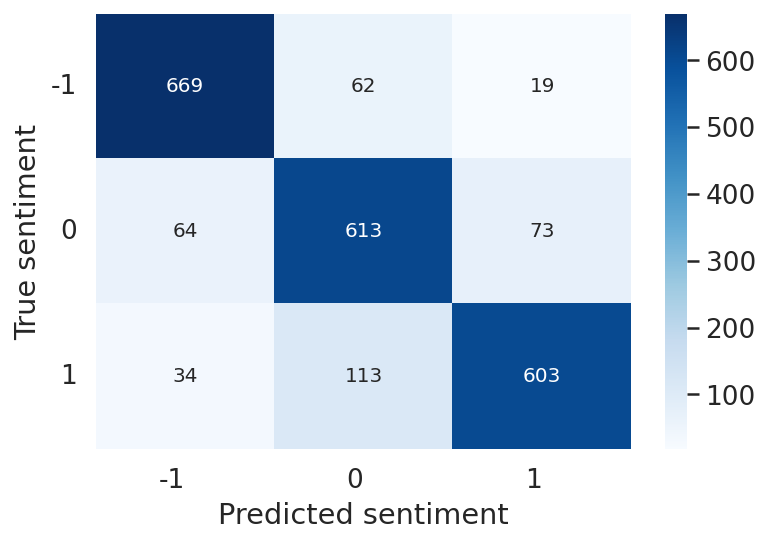

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=0, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
y_test[50:60]  #retrieves the true sentiment labels for the examples from index 50 to 59 (10 elements) in the test dataset.

In [ ]:
idx = 50               #  at index 50 This sets the variable idx to the value 50, indicating that we are interested in the example at index 50.

tweet_text = y_tweet_texts[idx]        #Retrieves the tweet text corresponding to the example at index 50. #likely contains the tweet texts for the test dataset.
#Retrieves the true sentiment label for the example at index 50 from the y_test array. This is the ground truth sentiment for the corresponding tweet.
true_sentiment = y_test[idx]
# Creates a DataFrame (pred_df) with two columns - class_names and values.
#class_names: Contains the names of sentiment classes (['-1', '0', '1']
pred_df = pd.DataFrame({
  'class_names': class_names,    #Contains the names of sentiment classes (['-1', '0', '1']).
  #y_pred_probs[idx] likely contains the predicted probabilities outputted by the model
  'values': y_pred_probs[idx]   #Contains the predicted probabilities for each sentiment class for the example at index 50.
})



 आमचे मार्गदर्शक, अहमदनगर शहराचे माजी महापौर व माजी नगराध्यक्ष दीप चव्हाण साहेबांना वाढदिवसाच्या मनःपूर्वक शुभेच्छा 




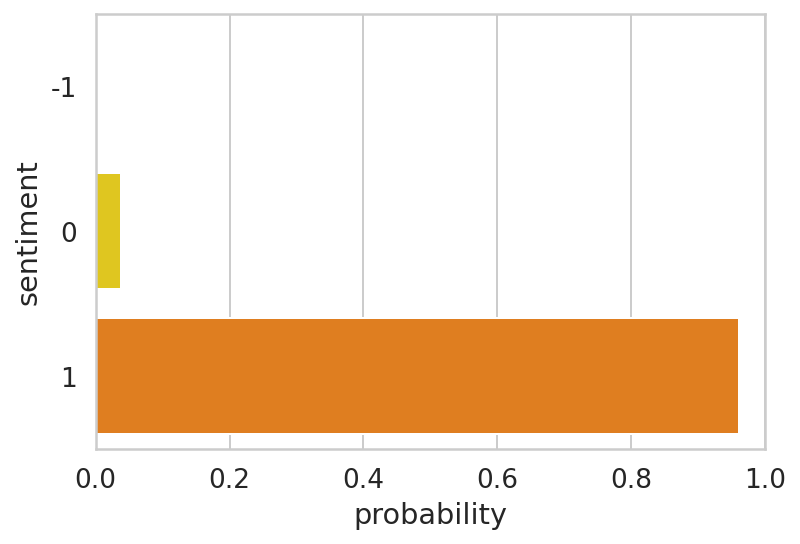

In [ ]:
#This part is printing the tweet text surrounded by newline characters to provide some separation in the output
print('\n\n',tweet_text, '\n\n')

#horizontal bar plot is created using Seaborn (sns).
# The x-axis represents the probability values ('values' column from the DataFrame pred_df),
#and the y-axis represents the class names ('class_names' column from pred_df). This plot visualizes the predicted probabilities for each sentiment class.


sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
#These lines set the labels for the y-axis and x-axis, providing context to the information presented in the plot.
plt.ylabel('sentiment')
plt.xlabel('probability')
#This line sets the x-axis limits to be between 0 and 1, ensuring that the probabilities are displayed within the valid probability range.
plt.xlim([0, 1]);

In [ ]:
y_test[14], y_tweet_texts[14]  #y_test[14] gives you the true sentiment label,
# and y_tweet_texts[14] gives you the text of the tweet at the 14th position in the dataset.

# Custom Prediction

Stripping White Spaces:

line = line.strip(): Removes leading and trailing white spaces.
Removing URLs:

Various re.sub calls are used to remove URLs from the text.
Replacing Specific Characters:

line = re.sub(r'\s+:\s+'," ",line): Replaces colon surrounded by spaces with a single space.
line = re.sub(r'\s+-\s+'," ",line): Replaces hyphen surrounded by spaces with a single space.
Splitting and Tokenizing:

re.split(r'\s+|[!$%&()*+./;<=>?\^{|}~'"]\s*', line)`: Splits the text into tokens based on spaces and a set of punctuation characters.
Removes empty tokens and tokens containing only spaces and newline characters.
Handling Special Tokens:

Filters tokens based on specific conditions (e.g., removing '@' mentions and certain punctuation).
Returning Processed Tokens:

Returns the list of processed tokens.

In [ ]:
# strip -> punctuations  -> @ mentions delete -> url delete ->  remove # from #-tokens -> stop words delete (no delete )  -> rare words no delete)
def preprocess(line):

  line = line.strip()                 #line.strip()Removes leading and trailing white spaces.
  line = re.sub(r'\S*\.com\S*'," ",line)              #re.sub calls are used to remove URLs from the text
  line = re.sub(r'\S*\.in\S*'," ",line)   #re.sub(r'\s+:\s+'," ",line): Replaces colon surrounded by spaces with a single space.
  line = re.sub(r'\S*\.net\S*'," ",line)
  line = re.sub(r'\S*\.me\S*'," ",line)
  line = re.sub(r'\s+:\s+'," ",line)  #re.sub(r'\s+-\s+'," ",line): Replaces hyphen surrounded by spaces with a single space.
  line = re.sub(r'\s+-\s+'," ",line)


  line = re.sub(r'/https?\/\/(.*\.(in))\//'," ",line)
  line = re.split(r'\s+|[!$%&()*+./;<=>?\^`{|}~\'\"]\s*', line)   #re.split(r'\s+|[!$%&()*+./;<=>?\^{|}~'"]\s*', line)`: Splits the text into tokens based on spaces and a set of punctuation characters.
  line = [token.strip() for token in line if token != '' and token != ' ' and token != '\n']

  if len(line) > 1:
    tokens = []
    for i in range(len(line)):
      if line[i][0] == '#':
        tokens.append(line[i][1:])
      elif line[i][0] == '@' or line[i][0] in string.punctuation :
        continue
      else:
        tokens.append(line[i])
    return tokens             #Returns the list of processed tokens.


purpose of the provided code is to preprocess the given tweet_text. The preprocessing involves cleaning the text and transforming it into a format suitable for further analysis or natural language processing tasks. The specific steps in the preprocess function include:

Stripping leading and trailing whitespaces from the text.
Using regular expressions to remove specific patterns, such as URLs and certain punctuations.
Tokenizing the text by splitting it based on whitespaces and specified delimiters.
Filtering out tokens starting with '#' or '@' and certain punctuation.
The final result is a cleaned and tokenized version of the input text, which is then joined into a string using whitespaces

In [ ]:
tweet_text = "नमो सरकारला साधी अडचने पार पाडण्याची बुद्धी नाही आहे. एकदम मूर्खपणाचे लक्षण आहे"
tweet_text = "प्रौढ प्रताप पुरंदर, क्षत्रिय कुलावतंस, सिंहासनाधीश्वर, महाराजाधिराज महाराज श्रीमंत श्री छत्रपती शिवाजी महाराज की जय"
tweet_text = "मनाचे वेधना किती सोसावे सामान्य माणसाने"
tweet_text = "माननीय महोदय संजय विचारे यांच्या अपघाताची बातमी आज कळाली. खूप वाईट वाटले."
tweet_text = "नमो सरकारला साधी अडचने पार पाडण्याची बुद्धी नाही आहे. एकदम मूर्खपणाचे लक्षण आहे"
tweet_text = "गढ आला पण माझा सिंह गेला"
tweet_text = "मैदानात हजारो कंडोम पाकीटं कुणी फेकली?; खुलासा होताच अधिकाऱ्यांनी डोक्यावर हात मारला"
tweet_text = "महाशिवरात्रीच्या सर्वांना हार्दिक हार्दिक शुभेच्छा"
tweet_text= "नमो सरकारला साधी अडचने पार पाडण्याची बुद्धी नाही आहे. एकदम मूर्खपणाचे लक्षण आहे"
tweet_text = "हिंदू धर्मात मुलांना लहानपणापासून आपला धर्मग्रंथ गीता शिकवला जात नाही हे सत्य आहे."
tweet_text = "प्रा. यारकुंडकरांसारख्या थोर वयकतीमत्वाचा परिचय देताना, मला आज प्रचंड अभिमान वाटतोय."
tweet_text = preprocess(tweet_text)
tweet_text = " ".join(tweet_text)

purpose of this code is to convert the preprocessed text into a format compatible with transformer-based models. The resulting encoded_tweet will be a dictionary containing the input IDs, token type IDs, and attention mask, in a format suitable for direct use in the model's forward pass. This is a common step when working with pre-trained language models

In [ ]:

encoded_tweet = tokenizer.encode_plus(
  tweet_text,                   #The preprocessed text that needs to be encoded.
  max_length=MAX_LEN,       # The maximum length of the resulting sequence. Tokens beyond this length will be truncated or padded accordingly.
  add_special_tokens=True,   #Whether to add special tokens like [CLS] and [SEP] to the encoded sequence.
  return_token_type_ids=True,   #Whether to return token type IDs, which indicate to which part of the input sequence a token belongs (useful for models that support sequence pairs).
  pad_to_max_length=True,  #Whether to pad the sequence to the specified max_length if it is less than that length.
  return_attention_mask=True, #Whether to return an attention mask, indicating which tokens should be attended to and which should be ignored.
  return_tensors='pt',  #Specifies the type of PyTorch tensors to be returned ('pt' for PyTorch tensors).
)


In [ ]:
#input_ids, attention_mask, and token_type_ids are moved to the specified device (GPU or CPU) using .to(device)
#The model is then used to make predictions on the provided input tensors (input_ids, attention_mask, token_type_ids).
input_ids = encoded_tweet['input_ids'].to(device)
attention_mask = encoded_tweet['attention_mask'].to(device)
token_type_ids = encoded_tweet['token_type_ids'].to(device)


#The output is obtained from the model, and torch.max is used to get the
#index of the maximum value along the specified dimension (in this case, dimension 1, which corresponds to the predicted classes).
output = model(input_ids, attention_mask, token_type_ids)
_, prediction = torch.max(output, dim=1)


#The original tweet_text and the predicted class are then printed.
print(f'Tweet text: {tweet_text}')
#The predicted class is obtained using class_names[prediction], where prediction is the index of the predicted class, and class_names is a list of class labels.
print(f'Sarcasm  : {class_names[prediction]}')

NameError: ignored

In [ ]:
import pandas as pd

# Example data (not actual user numbers)
data = {
    'Year': list(range(2012, 2017)),
    'Cloud_Users_Millions':[ 500, 625, 810, 1000, 1300]
}

# Create a DataFrame
cloud_users_df = pd.DataFrame(data)

# Display the dataset
print(cloud_users_df)


   Year  Cloud_Users_Millions
0  2012                   500
1  2013                   625
2  2014                   810
3  2015                  1000
4  2016                  1300


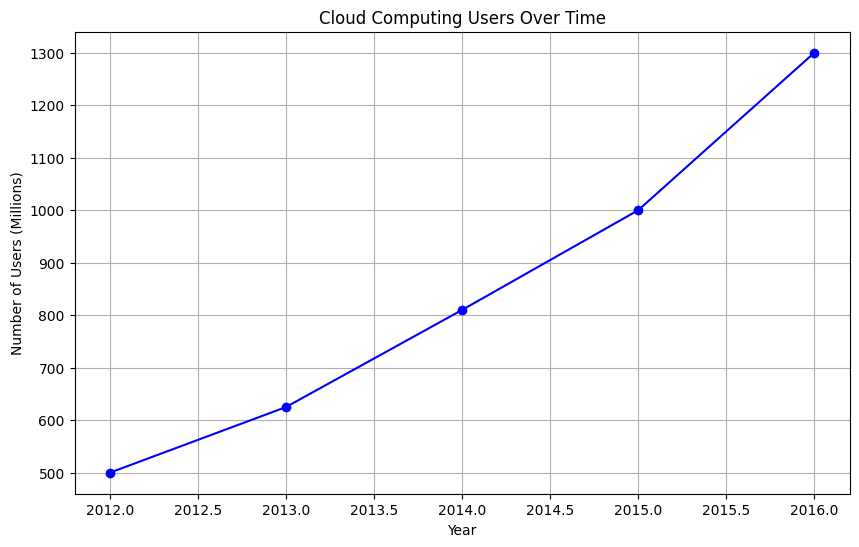

In [ ]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(cloud_users_df['Year'], cloud_users_df['Cloud_Users_Millions'], marker='o', linestyle='-', color='b')
plt.title('Cloud Computing Users Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Users (Millions)')
plt.grid(True)
plt.show()


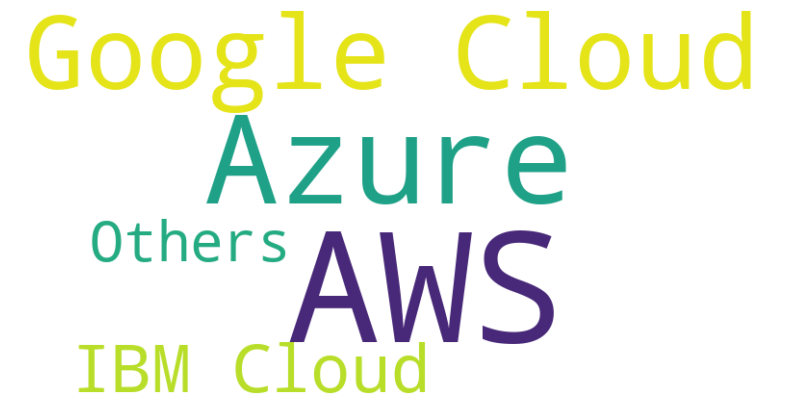

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Sample data
data = {'AWS': 50, 'Azure': 30, 'Google Cloud': 20, 'IBM Cloud': 15, 'Others': 10}

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(data)

# Plot the WordCloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


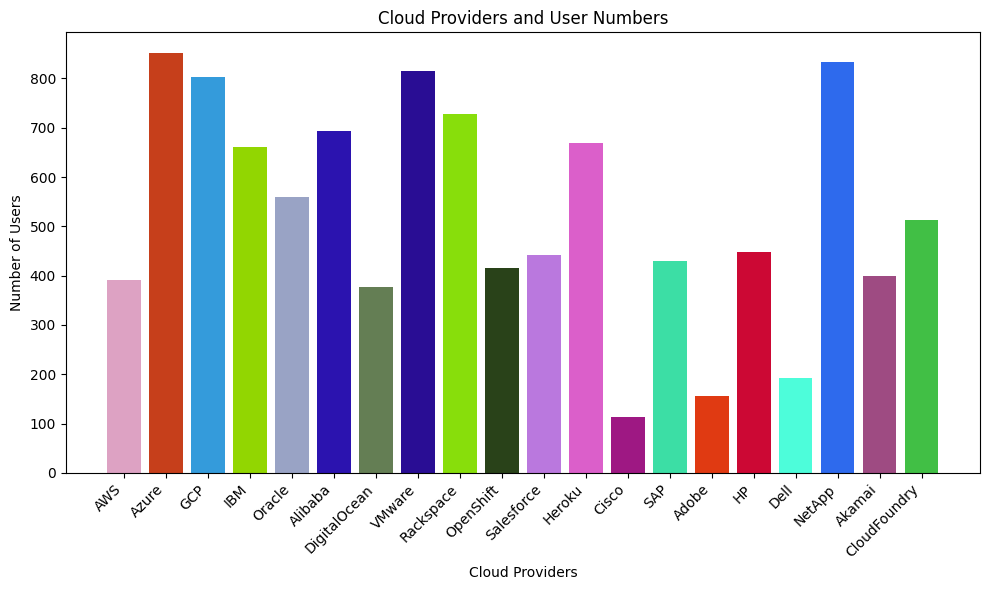

In [ ]:
import matplotlib.pyplot as plt
import random

cloud_providers = ["AWS", "Azure", "GCP", "IBM", "Oracle", "Alibaba", "DigitalOcean", "VMware", "Rackspace", "OpenShift",
                   "Salesforce", "Heroku", "Cisco", "SAP", "Adobe", "HP", "Dell", "NetApp", "Akamai", "CloudFoundry"]

# Assigning random colors to each cloud provider
colors = [f'#{random.randint(0, 0xFFFFFF):06x}' for _ in range(len(cloud_providers))]

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(cloud_providers, [random.randint(100, 1000) for _ in range(len(cloud_providers))], color=colors)
plt.title('Cloud Providers and User Numbers')
plt.xlabel('Cloud Providers')
plt.ylabel('Number of Users')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()

# Show the plot
plt.show()


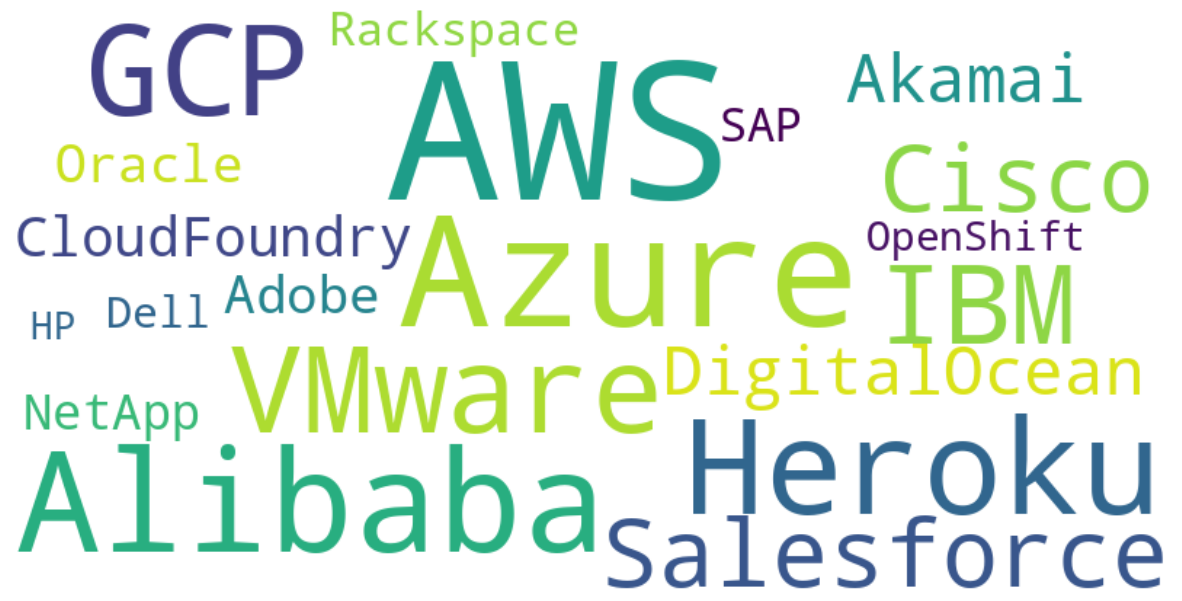

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Sample data
cloud_data = {'AWS': 50, 'Azure': 30, 'GCP': 20, 'IBM': 15, 'Oracle': 10,
              'Alibaba': 25, 'DigitalOcean': 12, 'VMware': 18, 'Rackspace': 8,
              'OpenShift': 6, 'Salesforce': 15, 'Heroku': 22, 'Cisco': 14,
              'SAP': 8, 'Adobe': 10, 'HP': 5, 'Dell': 7, 'NetApp': 9, 'Akamai': 12,
              'CloudFoundry': 11}

# Generate word cloud with font sizes based on user numbers
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      prefer_horizontal=1.0, relative_scaling=0.5,
                      colormap='viridis').generate_from_frequencies(cloud_data)

# Plot the WordCloud image
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
